# Create rainfall maps for suspect rainfall profiles in UKCP data

## User input

Enter in the details of the rainfall profile you want to map:


In [1]:
#file = 'Extract_Prof_proj3_e15_6h_ratio_ge15'
#groupid = 534925
file = 'Extract_Prof_proj1_e04_6h_ratio_ge15'
groupid = 406114

## Setup parameters

In [2]:
basedir = '/mnt/n/2024s1475/OutputData/6h'
grid_range = 30 # number of grid points to plot either side of the rainfall feature 
n_plots = 50

Set python imports

In [3]:
import os
import pandas as pd
import re
import iris
from ncdata.iris_xarray import cubes_from_xarray, cubes_to_xarray
import numpy as np
import iris.coord_categorisation as icc
from cftime import Datetime360Day
import matplotlib.pyplot as plt
import iris.plot as iplt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
#import cmocean


Set required functions

In [4]:
def calculate_precip_time_offset(row):
    """ 
    Calculate the offset (between 0 and 5 h) for each value of hourly rainfall
    """
    column = row['Max_TIME']
    hours_offset = 6 - int(column)  # Extract hour offset
    adjusted_hour = row['hour'] - hours_offset
    adjusted_day = row['day']
    adjusted_month = row['month']
    adjusted_year = row['year']

    while adjusted_hour < 0:
        adjusted_hour += 24
        adjusted_day -= 1
    while adjusted_day < 1:
        adjusted_day += 30
        adjusted_month -= 1
    while adjusted_month < 1:
        adjusted_month += 12
        adjusted_year -= 1

    return f"{adjusted_year:04d}-{adjusted_month:02d}-{adjusted_day:02d} {adjusted_hour:02d}:30"

def adjust_end_time(prof):
    prof[['year', 'month', 'day', 'hour']] = prof['end_date'].str.extract(r'(\d+)-(\d+)-(\d+) (\d+):\d+').astype(int)
    prof['end_date_adjusted'] = prof.apply(calculate_precip_time_offset, axis=1)
    return prof

def extract_dates_from_df(df: pd.DataFrame) -> pd.DataFrame:
    """ 
    Extract day, month and year strings from an input dataframe 
    """
    dates_df = df['end_date_adjusted'].str.extract(r'(\d+)-(\d+)-(\d+) (\d+):(\d+)').astype(str)
    dates_df.columns = ['year', 'month', 'day', 'hour', 'minute']
    return dates_df 

def make_date_string(prof):
    """
    Extract date information and format as needed
    """
    dates_df = extract_dates_from_df(prof)
    year=str(dates_df.iloc[0]['year'])
    month=str(dates_df.iloc[0]['month'])
    day=str(dates_df.iloc[0]['day'])
    hour=str(dates_df.iloc[0]['hour'])
    minute=str(dates_df.iloc[0]['minute'])
    date_string = f'{year}-{month}-{day} {hour}:{minute}'
    return date_string, year, month

def get_datetime_date(date_string):
    """
    Get the 360d datetime
    """
    datetime_date = Datetime360Day(int(date_string[0:4]), int(date_string[5:7]), int(date_string[8:10]), int(date_string[11:13]), int(date_string[14:16]))
    return datetime_date

def find_nearest_grid_indices(cube, lat, lon):
    """ 
    Find the nearest grid indices (lat, lon) to the rainfall features in the csv file
    """
    latitudes = cube.coord('latitude').points
    longitudes = cube.coord('longitude').points

    # Calculate distances to all grid points
    distances = np.sqrt((latitudes - lat)**2 + (longitudes - lon)**2)
    idx_flat = np.argmin(distances)

    # Convert flat index back to 2D indices
    lat_idx, lon_idx = np.unravel_index(idx_flat, latitudes.shape)
    return lat_idx, lon_idx

def find_nearest_grid_indices(cube, prof):
    """ 
    Find the nearest grid indices (lat, lon) to the rainfall features in the csv file
    """
    lat = prof['lat'].iloc[0]
    lon = prof['lon'].iloc[0]

    latitudes = cube.coord('latitude').points
    longitudes = cube.coord('longitude').points

    # Calculate distances to all grid points
    distances = np.sqrt((latitudes - lat)**2 + (longitudes - lon)**2)
    idx_flat = np.argmin(distances)

    # Convert flat index back to 2D indices
    lat_idx, lon_idx = np.unravel_index(idx_flat, latitudes.shape)
    return lat_idx, lon_idx

def get_ll_bounds(cube, prof, grid_range):
    """ 
    Determine the data bounds for plotting
    """
    lat_idx, lon_idx = find_nearest_grid_indices(cube[0,0], prof)
    lat_start = max(0, lat_idx - grid_range)
    lat_end = min(cube.shape[-2], lat_idx + grid_range)
    lon_start = max(0, lon_idx - grid_range)
    lon_end = min(cube.shape[-1], lon_idx + grid_range)
    return lat_start, lat_end, lon_start, lon_end

def find_nearest_time_indices(cube, prof):
    """ 
    Find the nearest time indices to the rainfall features in the csv file
    """   
    cube_copy = cube.copy()
    icc.add_categorised_coord(cube_copy, 'datetime', 'time', lambda coord, x: coord.units.num2date(x))
    date, year, month = make_date_string(prof)
    datetime_date = get_datetime_date(date)
    datetime_coord = cube_copy.coord('datetime')
    matching_indices = [i for i, dt in enumerate(datetime_coord.points) if dt == datetime_date]
    return matching_indices

def find_more_matches(rainfall_features,prof):
    """ 
    Subset rainfall_features for more features with the same year/month combo
    """   
    sub_rainfall = rainfall_features[rainfall_features['MONTH'].isin(prof['MONTH']) & rainfall_features['YEAR'].isin(prof['YEAR'])]
    return sub_rainfall

def subset_cube(cube, prof):
    """ 
    Subset the UKCP data for the area/datetime (+-1) around the selected rainfall feature
    """   
    matching_indices = find_nearest_time_indices(cube, prof)
    lat_start, lat_end, lon_start, lon_end = get_ll_bounds(cube, prof, grid_range)
    cube_subset = cube[0,
                   matching_indices[0]-1:matching_indices[0]+2,
                   lat_start:lat_end,
                   lon_start:lon_end]
    return cube_subset
    
def make_plot(cube, prof):
    """ 
    Make plots for the selected rainfall feature
    """   
    prof = adjust_end_time(prof)
    cube_subset = subset_cube(cube, prof)
    
    lat = prof['lat'].iloc[0]
    lon = prof['lon'].iloc[0]

    sns.set_theme()

    vmax = cube_subset.collapsed(['time', 'latitude', 'longitude'], iris.analysis.MAX).data
    
    fig, axs = plt.subplots(1, 3, figsize=(18,5), 
                        subplot_kw={'projection': ccrs.PlateCarree()})
    plt.suptitle(f"e{prof['Member'].iloc[0]} {date}; id: {groupid}; Max rain: {prof['Max_Accum'].iloc[0]}mm/hr; Ratio:{str(round(prof['Max_RATIO'].iloc[0],1))}")
    
    for i, ax in enumerate(axs.ravel()):

        ax.set_title('t '+'{0:+d}'.format(i-1)+' h')
        p = iplt.pcolormesh(cube_subset[i], 
                            cmap=plt.get_cmap('gist_ncar_r'), 
                            axes=ax, vmin=0, vmax=vmax)
        
        ax.coastlines()
        ax.add_feature(cfeature.BORDERS, linestyle='-', color='black')
        ax.add_feature(cfeature.COASTLINE, linestyle='-', color='black')
        
        gl = ax.gridlines(draw_labels=True, dms=False, x_inline=False, y_inline=False, linestyle='--', color='darkgrey')
        gl.top_labels = False
        gl.right_labels = False

        # declare text size
        XTEXT_SIZE = 10
        YTEXT_SIZE = 10
        gl.xlabel_style = {'size': XTEXT_SIZE, 'color': 'k'}
        gl.ylabel_style = {'size':YTEXT_SIZE, 'color': 'k'}

        
        ax.scatter(lon,
                   lat,
                   edgecolors='black',
                   facecolors='none',
                   linewidth=2,
                   s=80,
                   transform=ccrs.PlateCarree())

    cbar_ax = fig.add_axes([0.2,0.05,0.6,0.05])
    cbar = plt.colorbar(p, 
                        orientation='horizontal', 
                        cax=cbar_ax)
    cbar.ax.set_xlabel('Precipitation Rate (mm/hour)')
    

    plt.subplots_adjust(left=0.01, bottom=0.1, right=0.99, top=0.94)
    plt.show()
    return None

Code for retrieving UKCP data:
- Taken from `https://github.com/cedadev/opendap-python-example/blob/master/remote_nc_with_token.py`

In [5]:
"""
remote_nc_with_token.py
===================

Python script for reading a NetCDF file remotely from the CEDA archive. It demonstrates fetching
and using a download token to authenticate access to CEDA Archive data, as well as how to load
and subset the Dataset from a stream of data (diskless), without having to download the whole file.

Pre-requisites:

 - Python3.x
 - Python libraries (installed by Pip):

```
netCDF4
```

Usage:

```
$ python remote_nc_with_token.py <url> <var_id>
```

Example:

```
$ URL=https://dap.ceda.ac.uk/badc/ukcp18/data/marine-sim/skew-trend/rcp85/skewSurgeTrend/latest/skewSurgeTrend_marine-sim_rcp85_trend_2007-2099.nc
$ VAR_ID=skewSurgeTrend

$ python remote_nc_with_token.py $URL $VAR_ID
```

You will be prompted to provide your CEDA username and password the first time the script is run and
again if the token cached from a previous attempt has expired.

"""

import argparse
import json
#import os
import requests
import xarray as xr

from base64 import b64encode
from datetime import datetime, timezone
from getpass import getpass
from netCDF4 import Dataset
from urllib.parse import urlparse


# URL for the CEDA Token API service
TOKEN_URL = "https://services-beta.ceda.ac.uk/api/token/create/"
# Location on the filesystem to store a cached download token
TOKEN_CACHE = os.path.expanduser(os.path.join("~", ".cedatoken"))


def load_cached_token():
    """
    Read the token back out from its cache file.

    Returns a tuple containing the token and its expiry timestamp
    """

    # Read the token back out from its cache file
    try:
        with open(TOKEN_CACHE, "r") as cache_file:
            data = json.loads(cache_file.read())

            token = data.get("access_token")
            expires = datetime.strptime(data.get("expires"), "%Y-%m-%dT%H:%M:%S.%f%z")
            return token, expires

    except FileNotFoundError:
        return None, None


def get_token():
    """
    Fetches a download token, either from a cache file or
    from the token API using CEDA login credentials.

    Returns an active download token
    """

    # Check the cache file to see if we already have an active token
    token, expires = load_cached_token()

    # If no token has been cached or the token has expired, we get a new one
    now = datetime.now(timezone.utc)
    if not token or expires < now:

        if not token:
            print(f"No previous token found at {TOKEN_CACHE}. ", end="")
        else:
            print(f"Token at {TOKEN_CACHE} has expired. ", end="")
        print("Generating a fresh token...")

        print("Please provide your CEDA username: ", end="")
        username = input()
        password = getpass(prompt="CEDA user password: ")

        credentials = b64encode(f"{username}:{password}".encode("utf-8")).decode(
            "ascii"
        )
        headers = {
            "Authorization": f"Basic {credentials}",
        }
        response = requests.request("POST", TOKEN_URL, headers=headers)
        if response.status_code == 200:

            # The token endpoint returns JSON
            response_data = json.loads(response.text)
            token = response_data["access_token"]

            # Store the JSON data in the cache file for future use
            with open(TOKEN_CACHE, "w") as cache_file:
                cache_file.write(response.text)

        else:
            print("Failed to generate token, check your username and password.")

    else:
        print(f"Found existing token at {TOKEN_CACHE}, skipping authentication.")

    return token, expires


def open_dataset(url, download_token=None):
    """Open a NetCDF dataset from a remote file URL. Files requiring authentication
     will require an active download token associated with an authorised CEDa user.

    Returns a Python NetCDF4 Dataset object
    """

    headers = None
    # Add the download token to the request header if one is available
    if download_token:
        headers = {"Authorization": f"Bearer {download_token}"}

    response = requests.request("GET", url, headers=headers, stream=True)
    if response.status_code != 200:
        print(
            f"Failed to fetch data. The response from the server was {response.status_code}"
        )
        return
    
    #file_like_object = io.BytesIO(response.content)
    #dataset = xr.open_dataset(file_like_object, engine="h5netcdf")
    #return dataset

    filename = os.path.basename(urlparse(url).path)
    print(f"Opening Dataset from file {filename} ...")
    # To avoid downloading the whole file, we create an "in-memory" Dataset from the response
    # See: https://unidata.github.io/netcdf4-python/#in-memory-diskless-datasets
    return Dataset(filename, memory=response.content)

def initiate_opendap(url, var_id):
    token, expires = get_token()
    if token:
        # Now that we have a valid token, we can attempt to open the Dataset from a URL.
        # This will only work if the token is associated with a CEDA user that has been granted
        # access to the data (i.e. if they can already download the file in a browser).
        # 
        print(f"Fetching information about variable '{var_id}' using data URL: '{url}'")
        if token:
            print((
                f"Using download token '{token[:5]}...{token[-5:]}' for authentication."
                f" Token expires at: {expires}."
            ))
        else:
            print("No DOWNLOAD_TOKEN found in environment.")

        nc_data = open_dataset(url, download_token=token)

        # Now we can print some properties of the dataset.
        # 
        print("\n[INFO] Global attributes:")
        for attr in nc_data.ncattrs():
            print("\t{}: {}".format(attr, nc_data.getncattr(attr)))

        print("\n[INFO] Variables:\n{}".format(nc_data.variables))
        print("\n[INFO] Dimensions:\n{}".format(nc_data.dimensions))

        print("\n[INFO] Max and min variable: {}".format(var_id))
        variable = nc_data.variables[var_id][:]
        units = nc_data.variables[var_id].units
        print(
            "\tMin: {:.6f} {}; Max: {:.6f} {}".format(
                variable.min(), units, variable.max(), units
            )
        )

        ds = xr.open_dataset(xr.backends.NetCDF4DataStore(nc_data))
        cubes = cubes_from_xarray(ds)
        cube = cubes[0]
        return cube


## Load in the processed rainfall profiles data that identifies unphysical rainfall features

In [6]:
filepath = os.path.join(basedir, file+'.csv')
rainfall_features_ALL = pd.read_csv(filepath)
rainfall_features_ALL

Projection_slice_ID  Member  WCID          end_date   lon    lat  \
0                        1       4     0  1999-06-12 13:30 -7.57  56.94   
1                        1       4     0  1987-07-10 14:30 -7.57  56.94   
2                        1       4     0  1981-07-18 13:30 -7.57  56.94   
3                        1       4     0  1984-05-14 12:30 -7.57  56.94   
4                        1       4     0  1986-07-21 14:30 -7.53  56.96   
...                    ...     ...   ...               ...   ...    ...   
61112                    1       4    12  1993-06-23 00:30 -1.88  53.54   
61113                    1       4    12  1981-07-18 16:30 -1.84  53.50   
61114                    1       4    12  1988-07-16 17:30 -1.84  53.50   
61115                    1       4    12  1988-08-25 14:30 -1.84  53.52   
61116                    1       4    12  1988-07-19 12:30 -1.81  53.50   

       Total_accum  TIME_1  TIME_2  TIME_3  TIME_4  TIME_5  TIME_6  RP  \
0            35.22    0.00    0.00    0.00    0.80   33.61    0.80   5   
1            38.82    0.00    0.00    0.00   33.89    2.06    2.87   5   
2            49.67    0.00    0.00    0.00    0.00    8.96   40.72  10   
3            53.06    0.00    0.00    0.00   45.63    7.43    0.00  30   
4            48.87    0.00    0.00    0.00    9.10   39.60    0.17  10   
...            ...     ...     ...     ...     ...     ...     ...  ..   
61112        41.90   36.30    5.59    0.00    0.00    0.00    0.00   5   
61113        45.12    1.78    6.49   34.05    2.42    0.35    0.03  10   
61114        35.51    0.00    0.00   34.24    1.25    0.00    0.01   5   
61115        58.72   45.13   10.46    3.02    0.10    0.00    0.00  30   
61116        53.80    0.00    0.00    0.00   43.99    9.81    0.00  30   

       Max_Accum  Max_TIME  YEAR  MONTH  group_id   Max_RATIO  
0          33.61         5  1999      6        14  105.031250  
1          33.89         4  1987      7        15   34.371197  
2          40.72         6  1981      7        17   22.723214  
3          45.63         4  1984      5        18   30.706595  
4          39.60         5  1986      7        24   21.359223  
...          ...       ...   ...    ...       ...         ...  
61112      36.30         1  1993      6    487392   32.468694  
61113      34.05         3  1981      7    487410   15.379404  
61114      34.24         3  1988      7    487411  135.873016  
61115      45.13         1  1988      8    487428   16.616348  
61116      43.99         4  1988      7    487441   22.420999  

[61117 rows x 20 columns]

In [7]:
rainfall_features = rainfall_features_ALL[(rainfall_features_ALL['Max_RATIO'] >= 50)]
#rainfall_features = rainfall_features_ALL


- Extract rainfall profile for specified `group_id`
- Need to modify the date string to account for time offset. 
- First extract the `year`, `month`, `day` and `hour` parts from the `end_date` column
- Then calculate the time offset for the maximum rainfall in the 6-h period and adjust the day, month and year for consistency with the 360-day calendar

In [8]:
prof = rainfall_features.loc[rainfall_features['group_id'] == groupid]
prof = adjust_end_time(prof)
prof

Projection_slice_ID  Member  WCID          end_date   lon    lat  \
50442                    1       4    10  1981-06-03 16:30 -1.71  51.74   

       Total_accum  TIME_1  TIME_2  TIME_3  ...  Max_TIME  YEAR  MONTH  \
50442        39.86     0.0     0.0    0.65  ...         4  1981      6   

       group_id   Max_RATIO  year  month  day  hour  end_date_adjusted  
50442    406114  115.787879  1981      6    3    16   1981-06-03 14:30  

[1 rows x 25 columns]

## Download UKCP18 Local data file so can map rainfall for suspect profile

- First get date of rainfall profile
- Then set the url
- Retrieve the data
- Convert to iris cube from xarray dataset

In [10]:
#date, year, month = make_date_string(prof)
year = 2024 
month = 12
ensemble_member = re.search('_e(.+?)_', file).group(1)
url =f'https://dap.ceda.ac.uk/badc/ukcp18/data/land-cpm/uk/2.2km/rcp85/{ensemble_member}/pr/1hr/v20210615/pr_rcp85_land-cpm_uk_2.2km_{ensemble_member}_1hr_{year}{month}01-{year}{month}30.nc?download=1'
var_id = 'pr'

cube=initiate_opendap(url,var_id)

Found existing token at /home/shardy08/.cedatoken, skipping authentication.
Fetching information about variable 'pr' using data URL: 'https://dap.ceda.ac.uk/badc/ukcp18/data/land-cpm/uk/2.2km/rcp85/04/pr/1hr/v20210615/pr_rcp85_land-cpm_uk_2.2km_04_1hr_20241201-20241230.nc?download=1'
Using download token 'eyJhb...YO43A' for authentication. Token expires at: 2024-12-16 10:30:45.587883+00:00.
Opening Dataset from file pr_rcp85_land-cpm_uk_2.2km_04_1hr_20241201-20241230.nc ...


KeyboardInterrupt: 

## Create plots

In [ ]:
sub_rainfall = find_more_matches(rainfall_features,prof)
sub_rainfall = sub_rainfall.sample(frac = 1)
sub_rainfall

Projection_slice_ID  Member  WCID          end_date   lon    lat  \
1056                     1       4     0  1981-06-12 15:30 -6.24  57.59   
1656                     1       4     0  1981-06-13 13:30 -5.84  56.42   
14534                    1       4     1  1981-06-13 11:30 -3.14  56.94   
47999                    1       4     9  1981-06-16 15:30 -2.55  50.66   
17101                    1       4     2  1981-06-03 18:30 -3.30  52.52   
...                    ...     ...   ...               ...   ...    ...   
10007                    1       4     1  1981-06-14 16:30 -4.37  55.07   
19634                    1       4     2  1981-06-03 19:30 -1.85  53.00   
8376                     1       4     1  1981-06-14 17:30 -4.82  55.72   
3477                     1       4     0  1981-06-13 19:30 -5.25  57.87   
49199                    1       4     9  1981-06-03 16:30 -2.07  50.90   

       Total_accum  TIME_1  TIME_2  TIME_3  TIME_4  TIME_5  TIME_6  RP  \
1056         49.32    0.30    0.00   47.71    1.24    0.00    0.06  10   
1656         38.77    0.00    0.00    0.00    0.00    0.15   38.62   5   
14534        47.54    0.00    0.00    0.00    0.00   44.41    3.13  10   
47999        40.67    0.00   39.78    0.66    0.00    0.02    0.22   5   
17101        57.07    0.00    0.00    4.94   52.05    0.08    0.00  30   
...            ...     ...     ...     ...     ...     ...     ...  ..   
10007        37.71    0.00   34.89    0.32    2.05    0.38    0.06   5   
19634        50.05    0.00    0.00    0.00    0.00   49.91    0.14  10   
8376         36.98    0.00    0.00   36.98    0.00    0.00    0.00   5   
3477         65.45    2.24    0.75   59.68    2.79    0.00    0.00  50   
49199        43.81    0.00    0.00    0.10   41.56    2.15    0.00  10   

       Max_Accum  Max_TIME  YEAR  MONTH  group_id     Max_RATIO  
1056       47.71         3  1981      6      6429    149.093750  
1656       38.62         6  1981      6     13329   1287.333333  
14534      44.41         5  1981      6    130438     70.942492  
47999      39.78         2  1981      6    393502    221.000000  
17101      52.05         4  1981      6    152434     51.842629  
...          ...       ...   ...    ...       ...           ...  
10007      34.89         2  1981      6     91499     62.081851  
19634      49.91         5  1981      6    169007   1782.500000  
8376       36.98         3  1981      6     76314  99999.000000  
3477       59.68         3  1981      6     35972     51.626298  
49199      41.56         4  1981      6    400058     92.355556  

[676 rows x 20 columns]

In [13]:
cube

<iris 'Cube' of lwe_precipitation_rate / (mm/hour) (ensemble_member: 1; time: 720; grid_latitude: 606; grid_longitude: 484)>

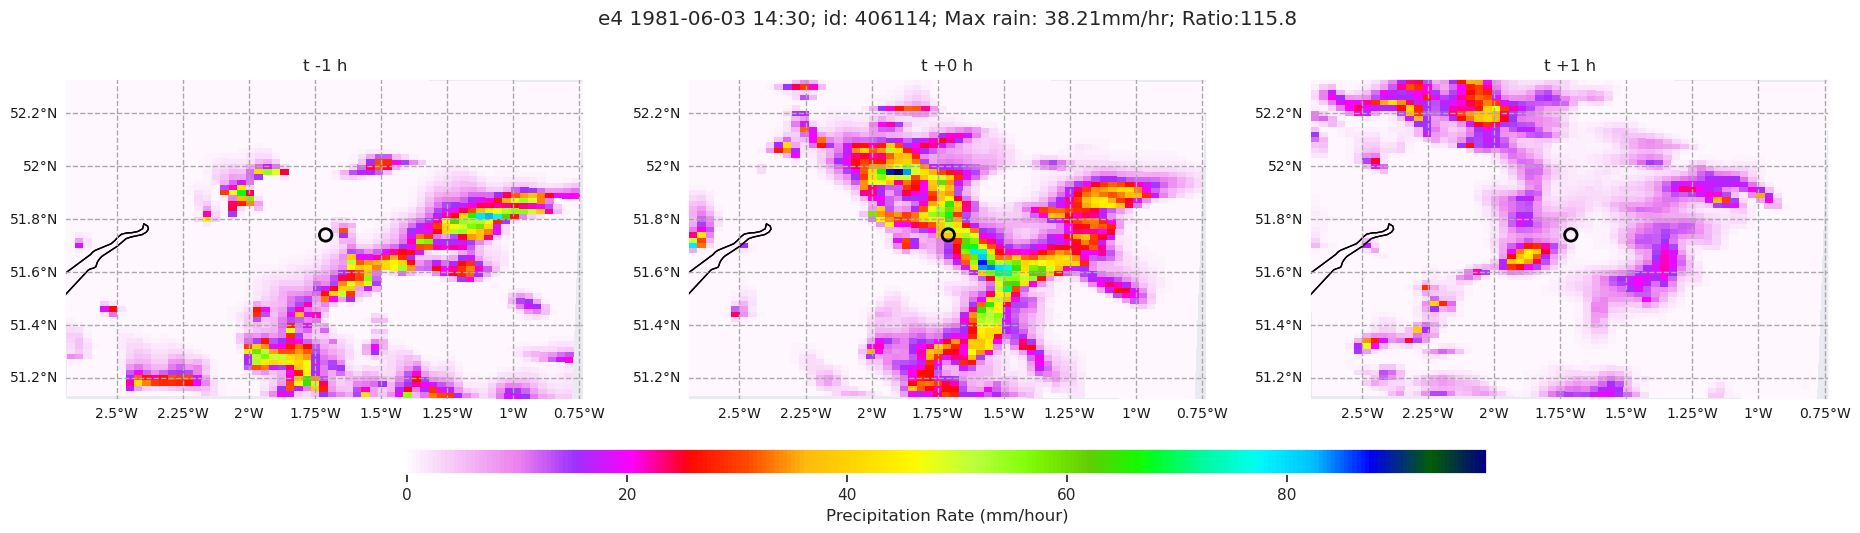

In [11]:
make_plot(cube, prof)

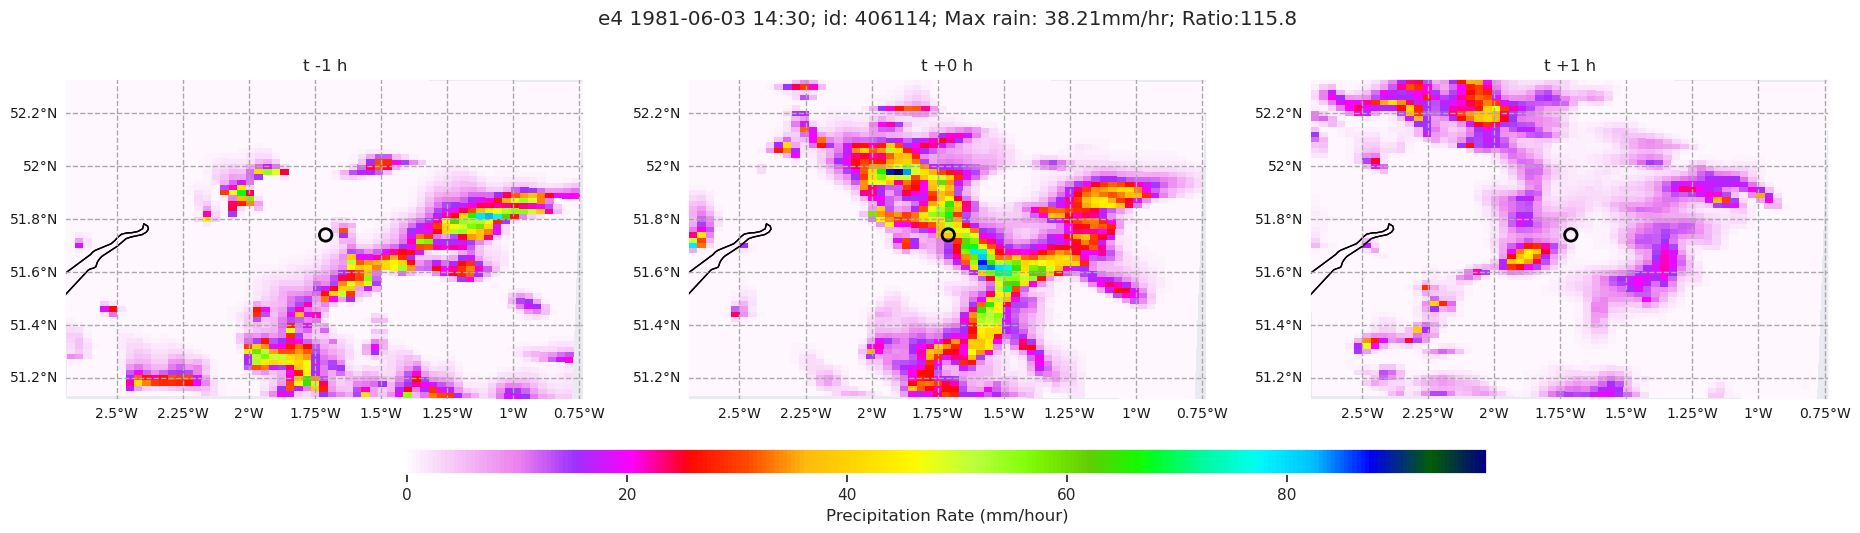

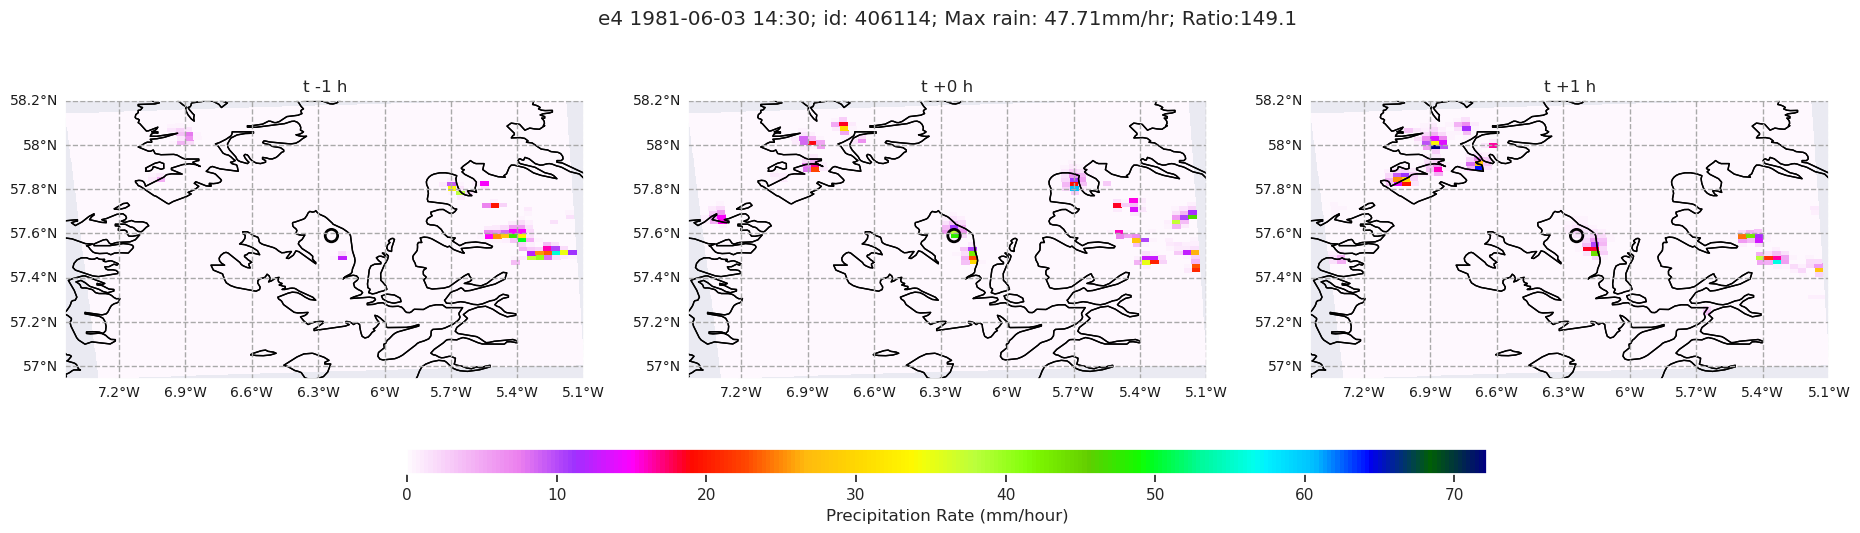

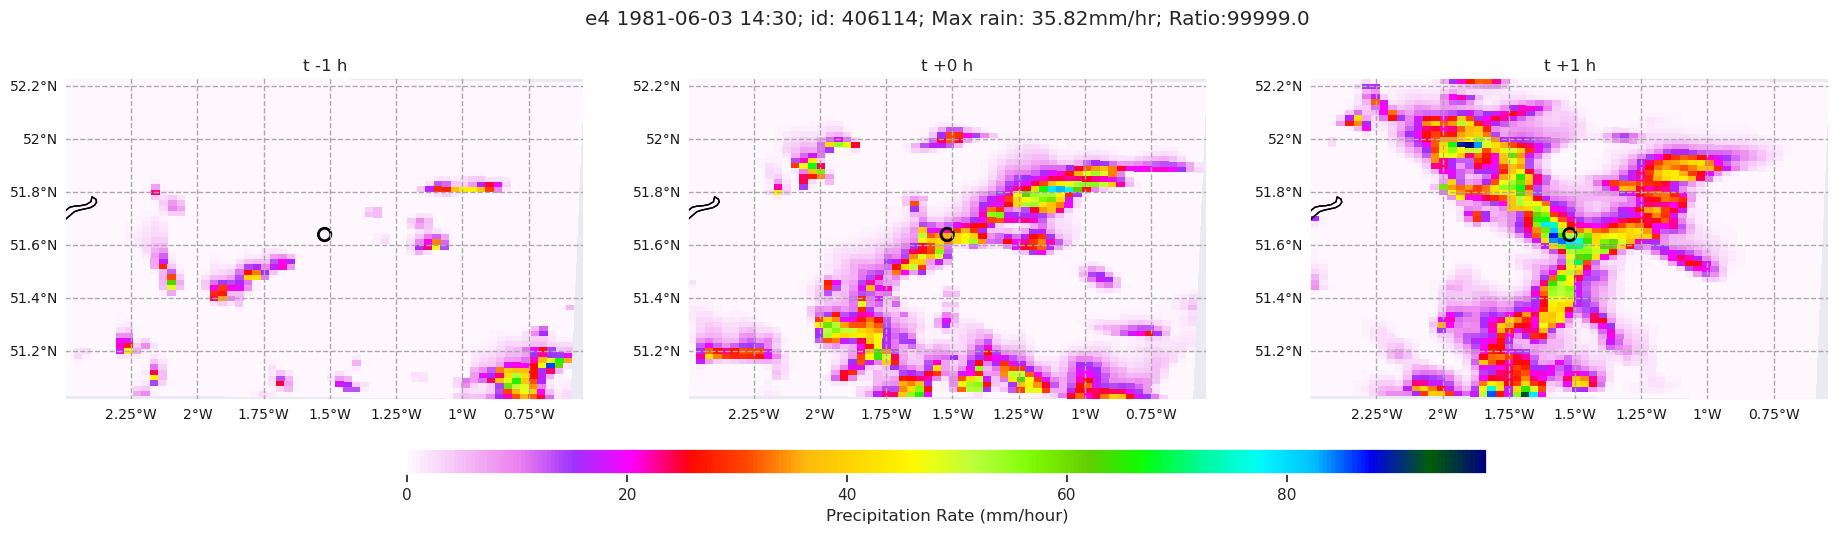

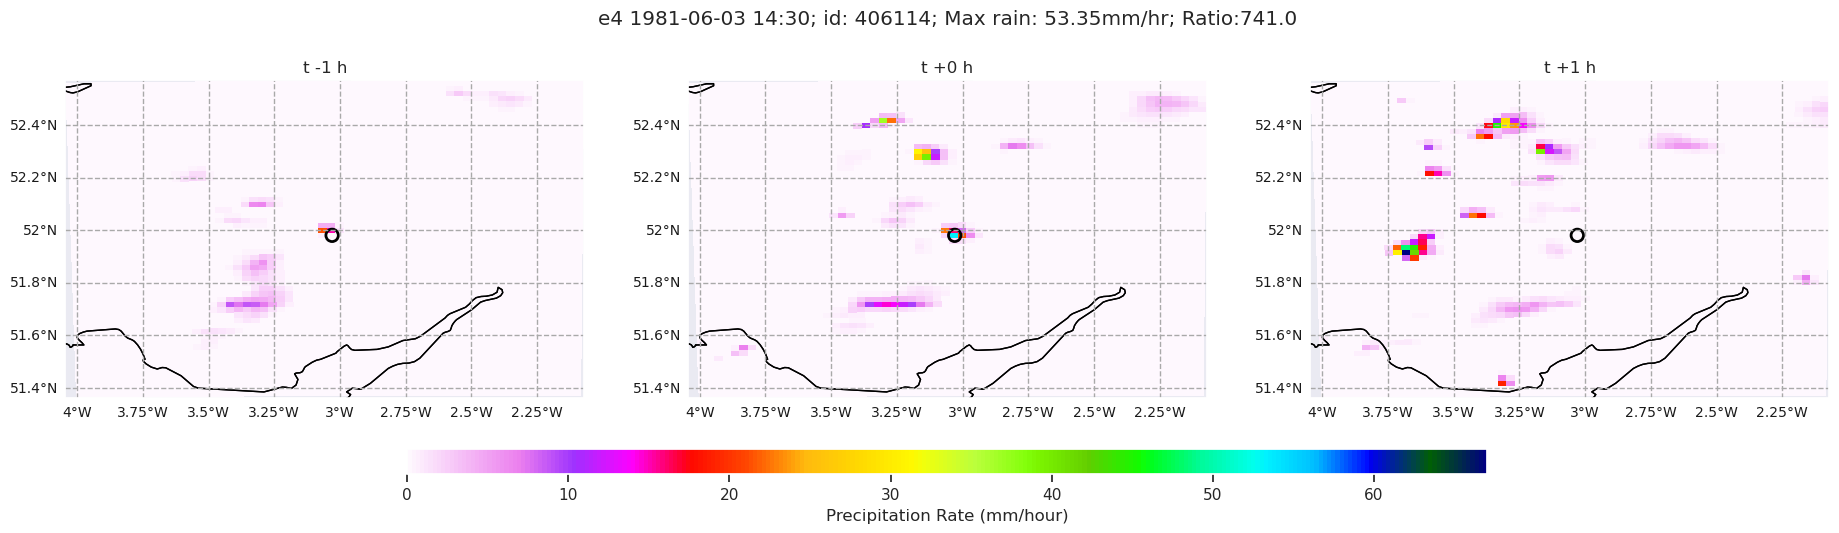

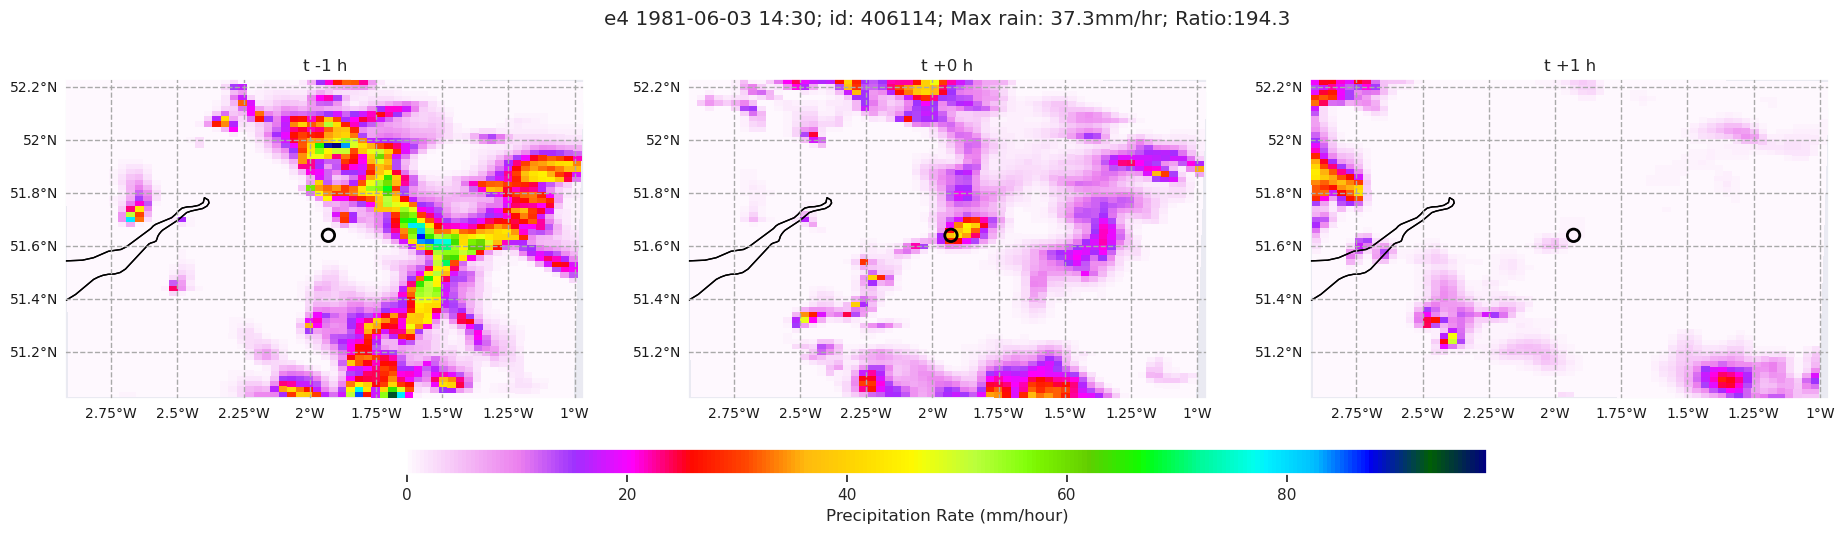

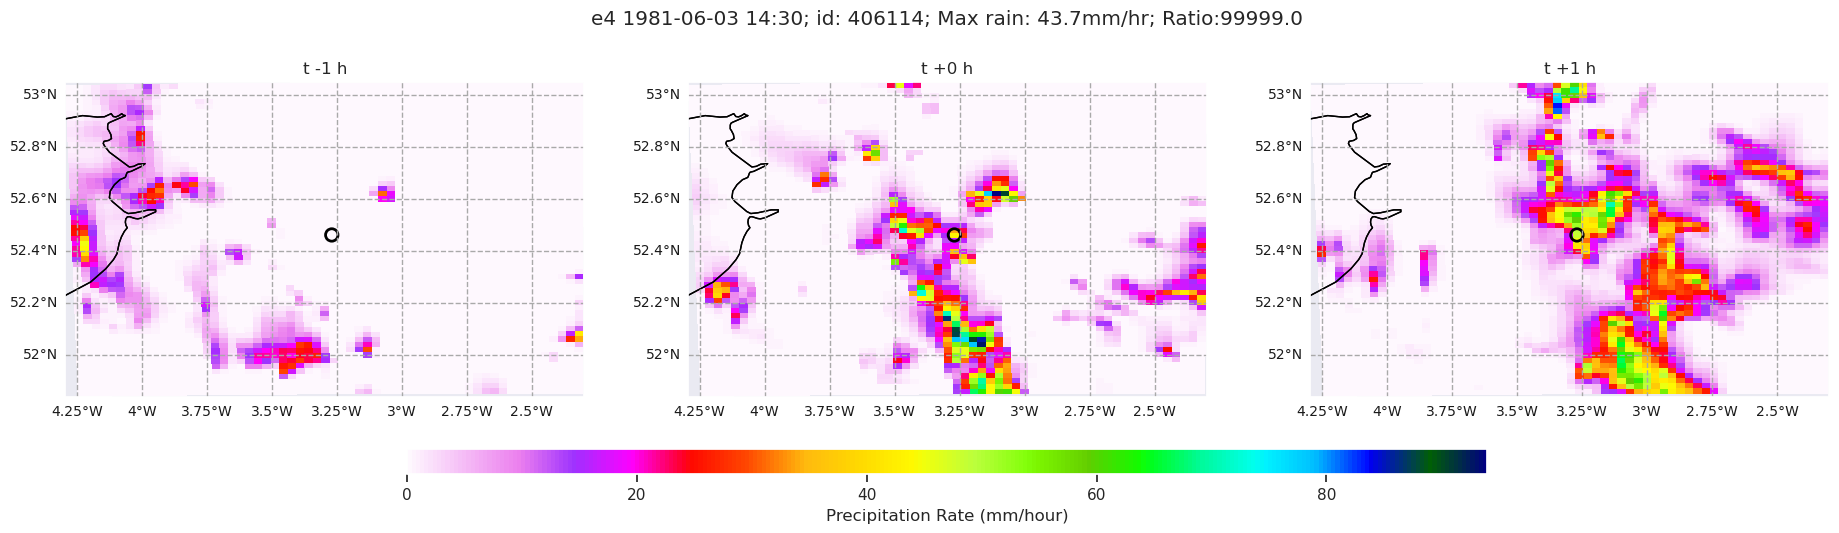

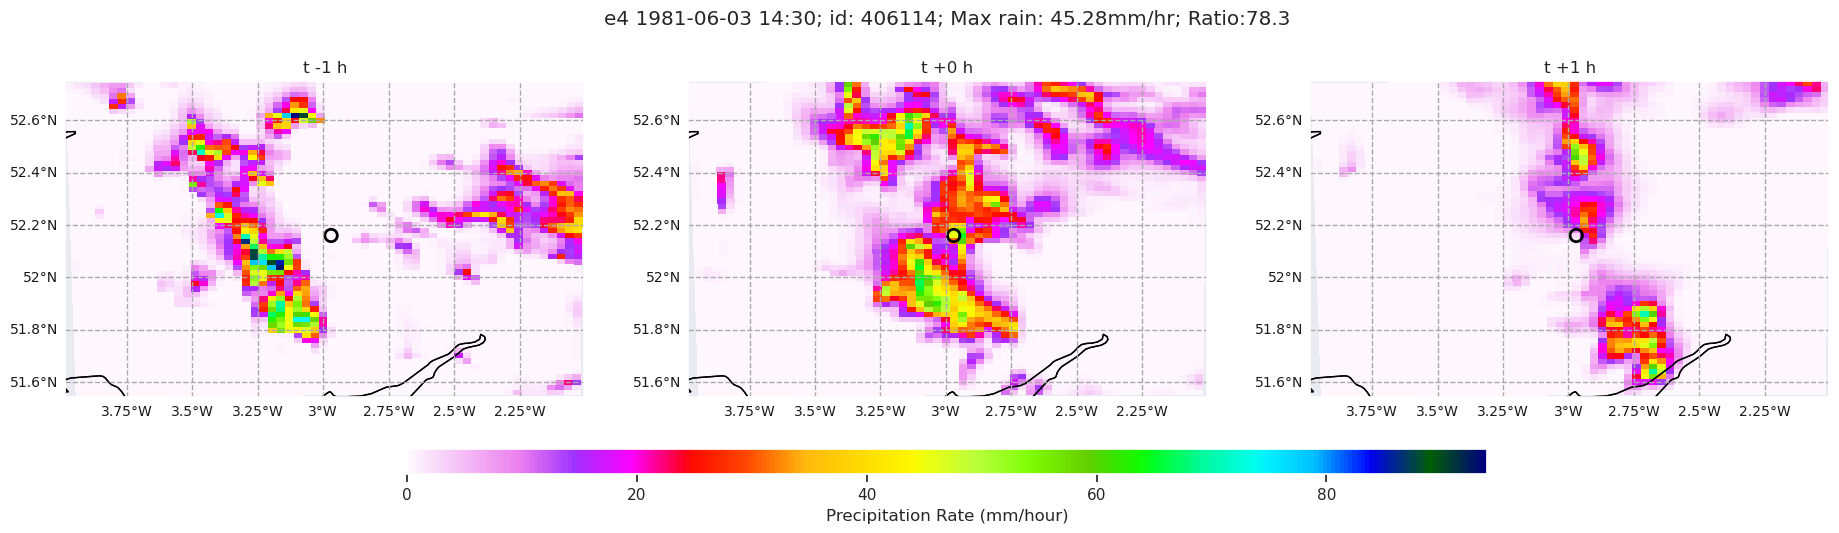

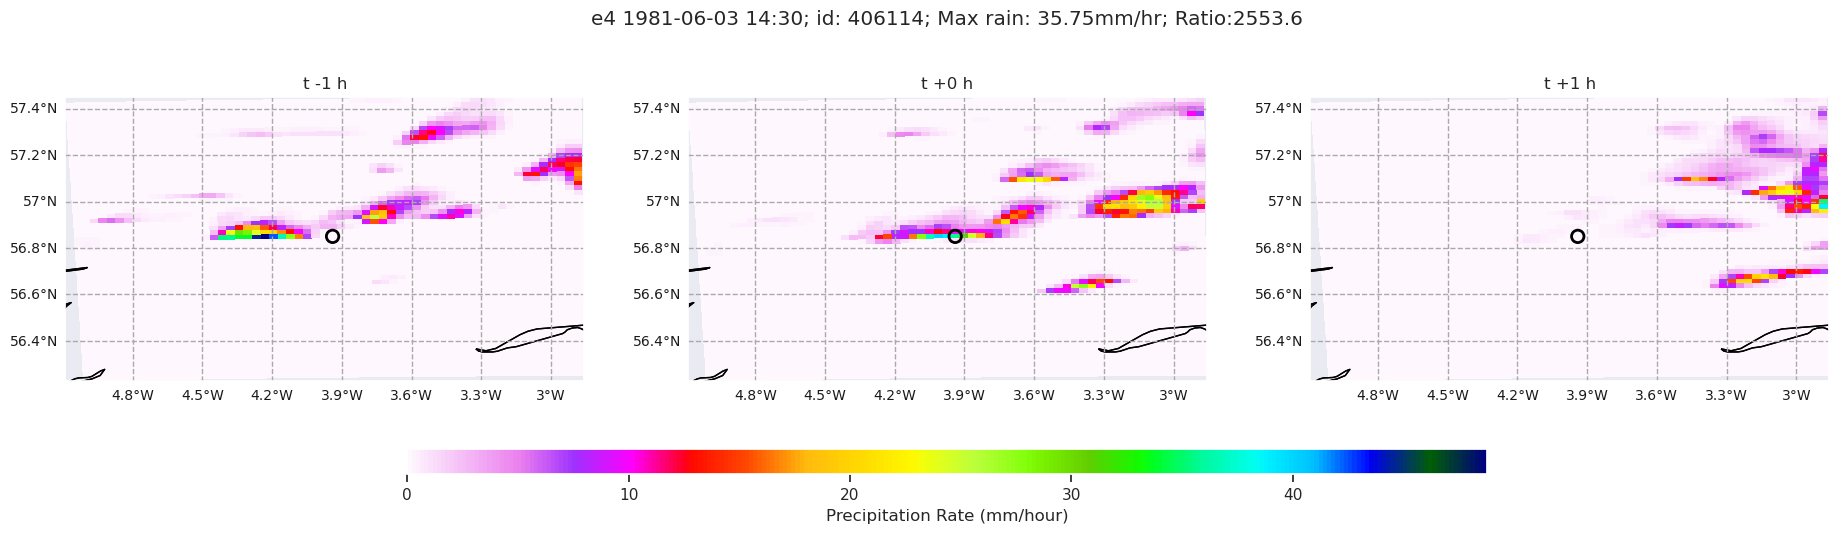

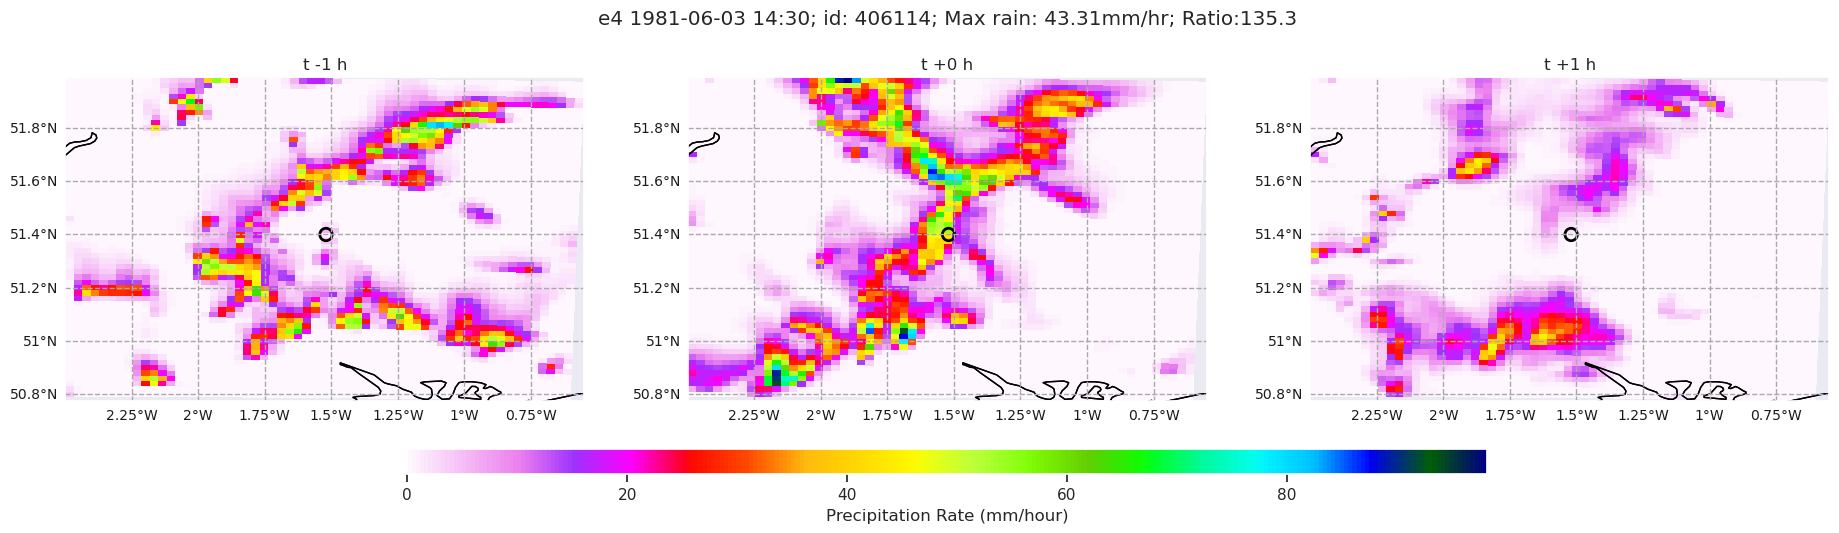

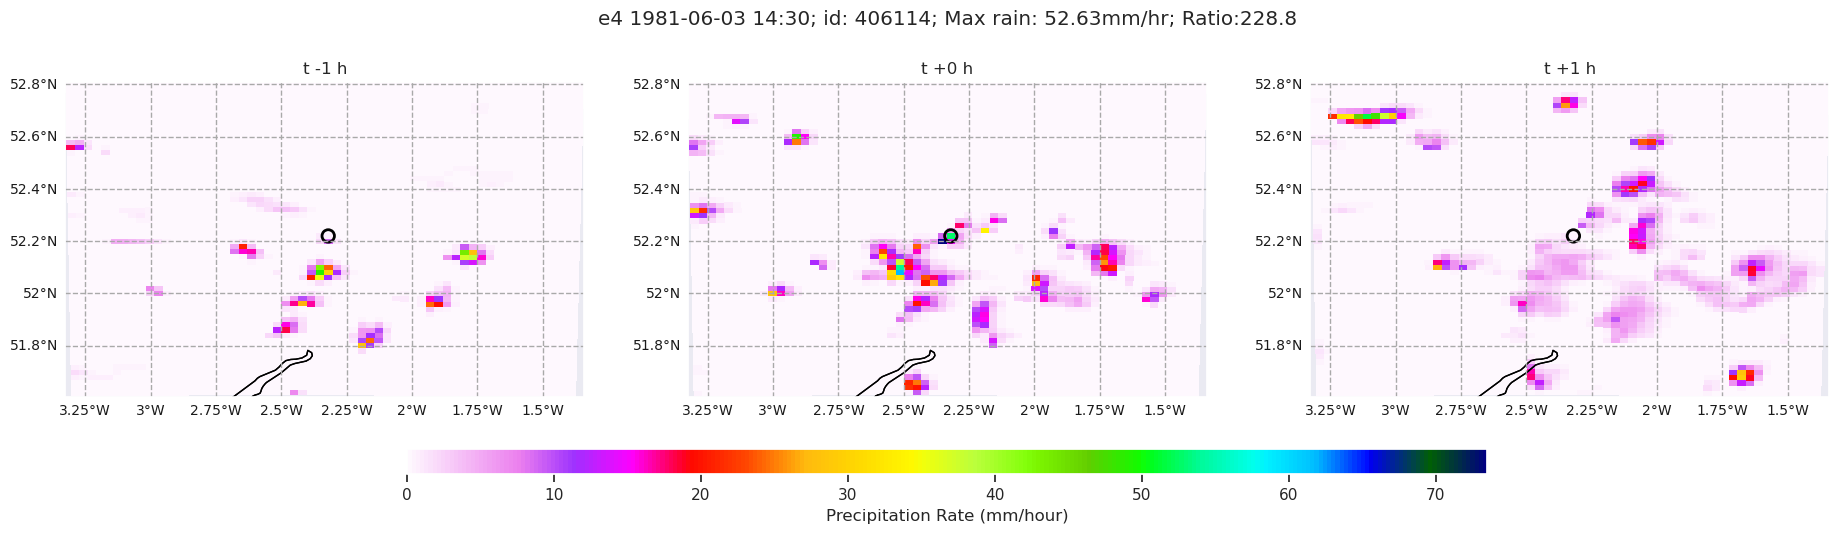

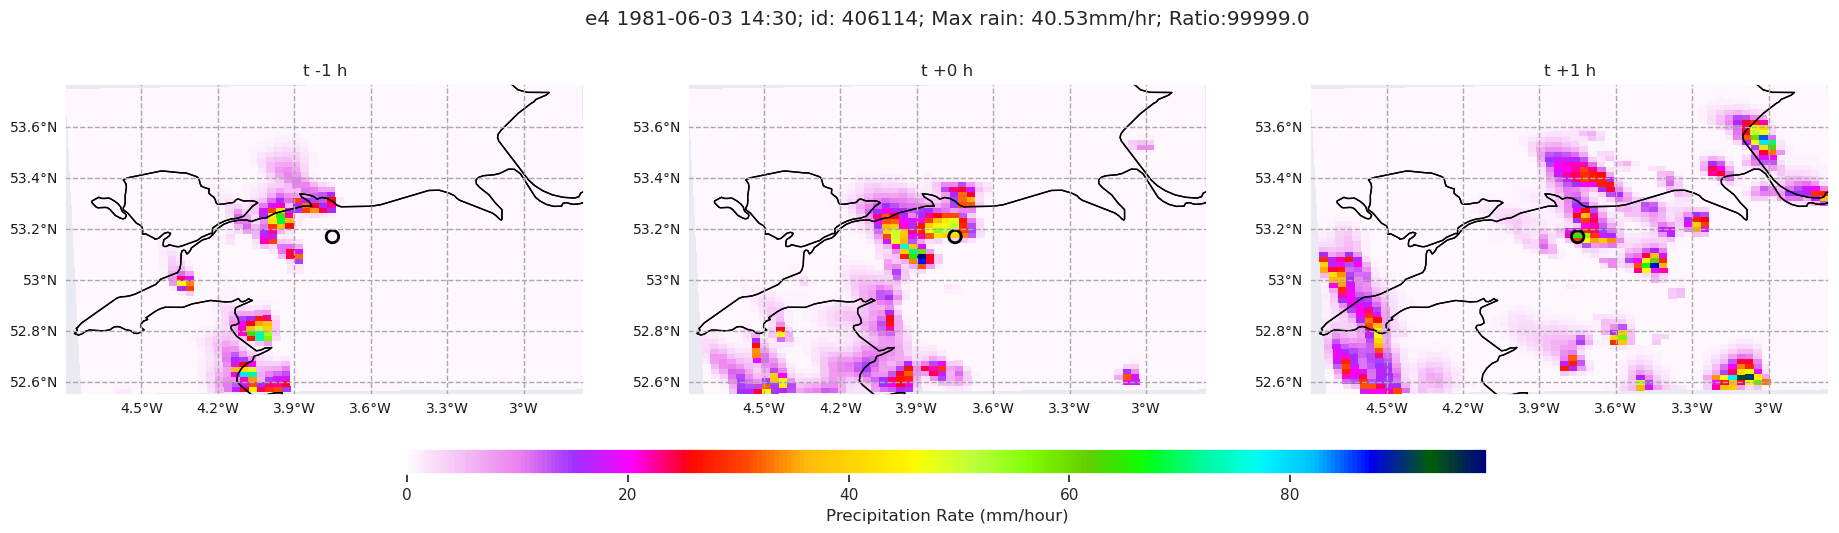

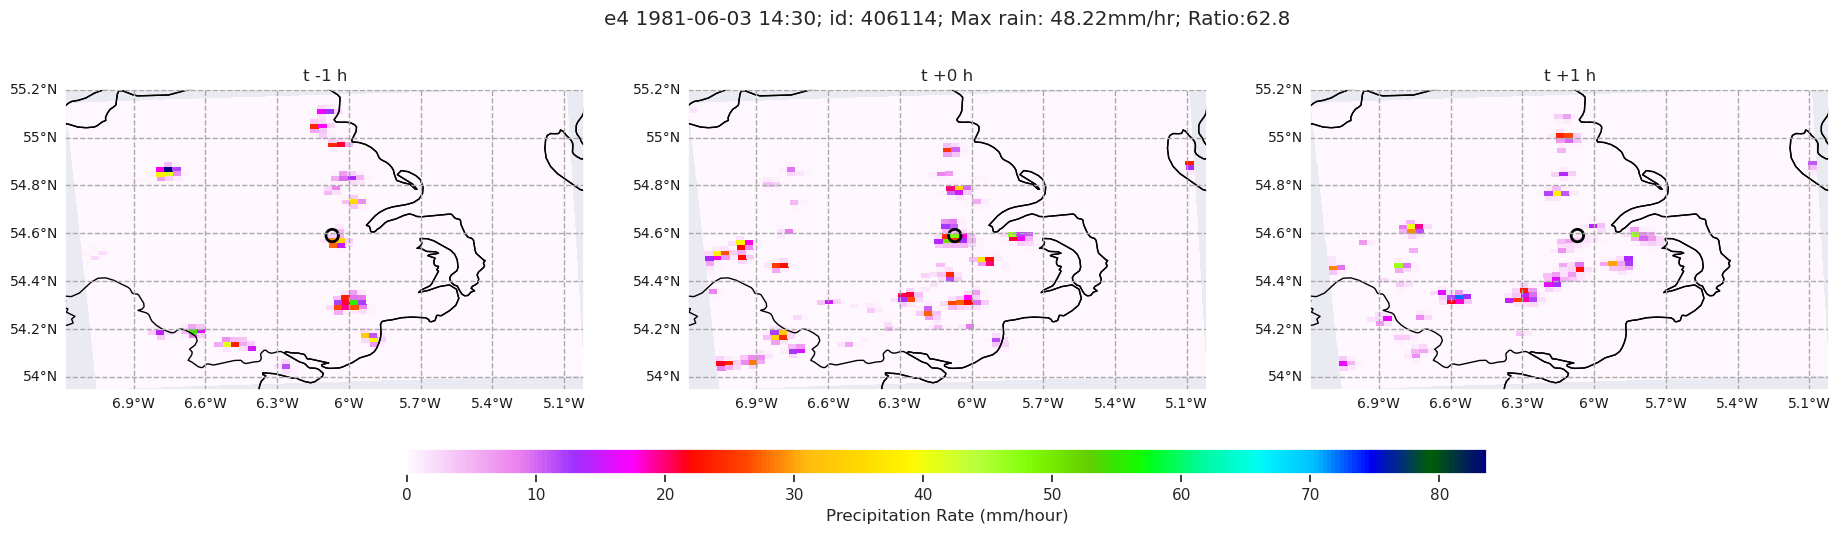

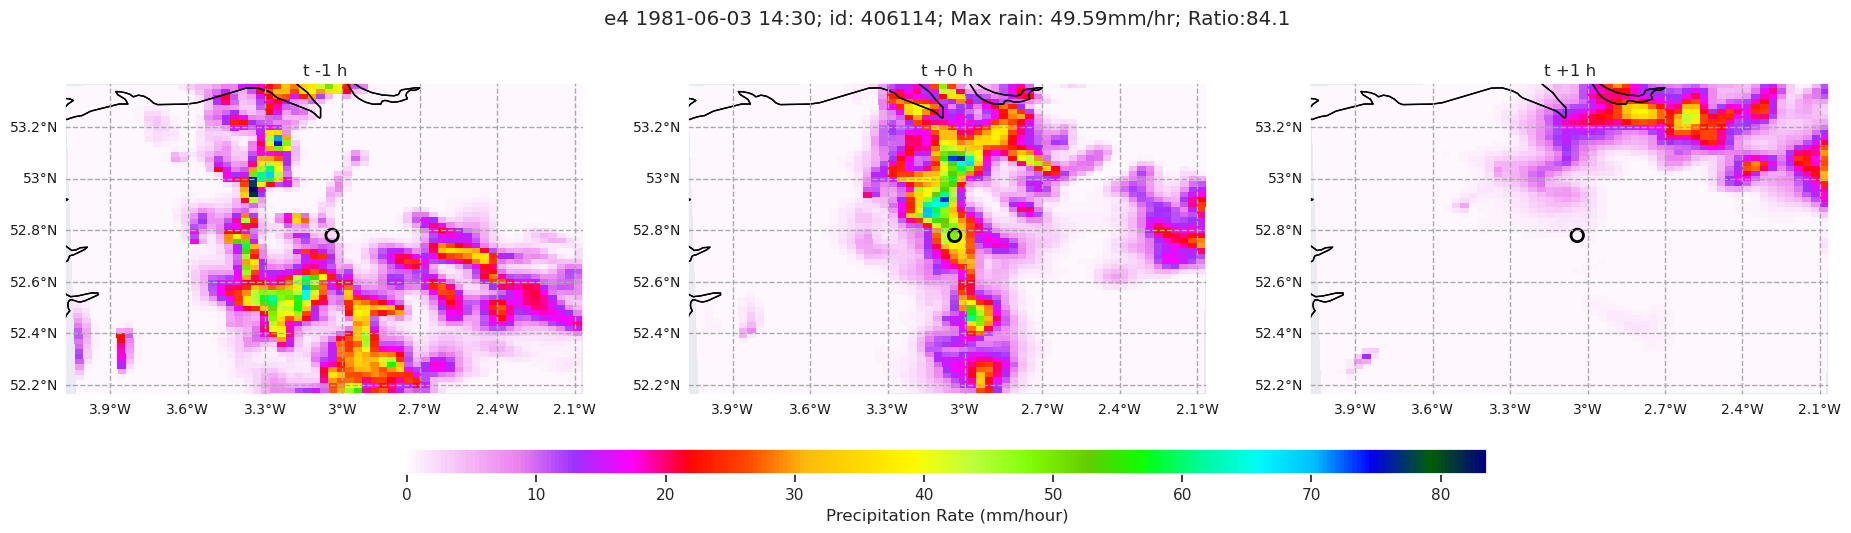

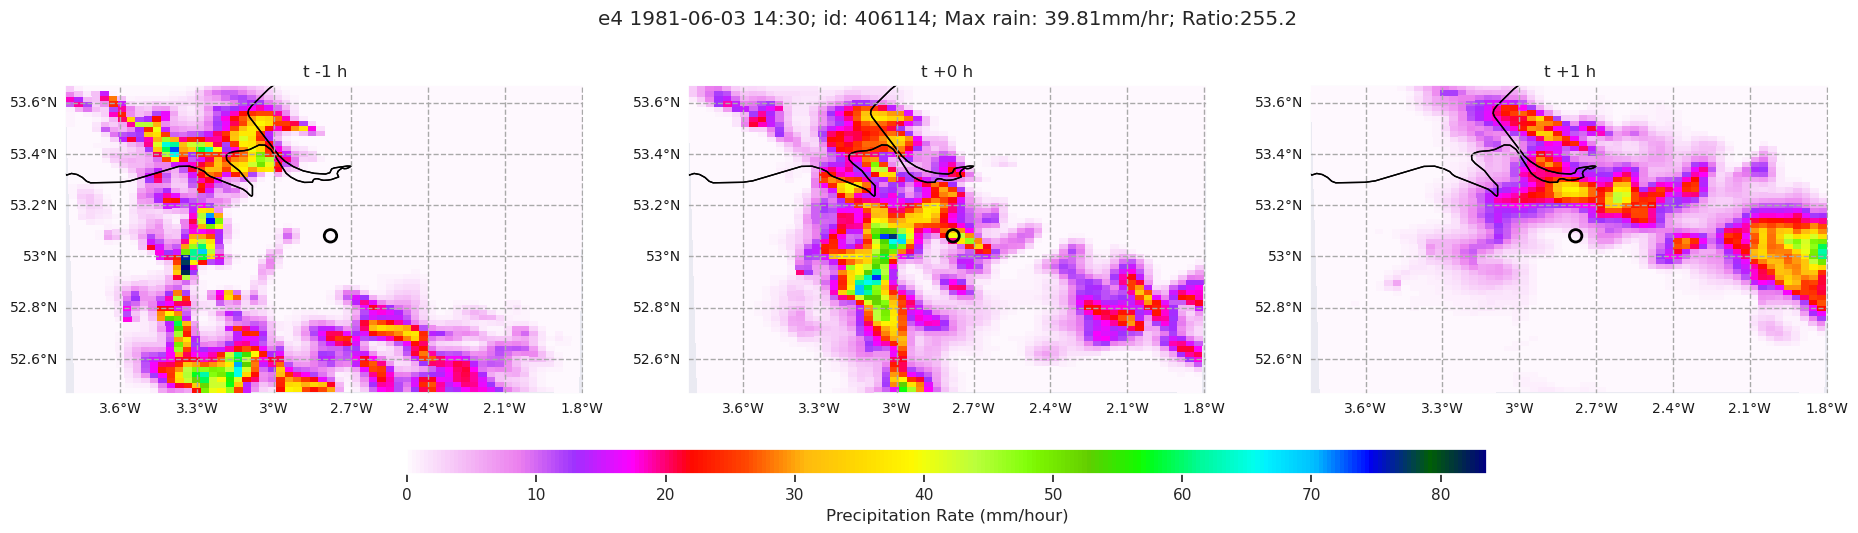

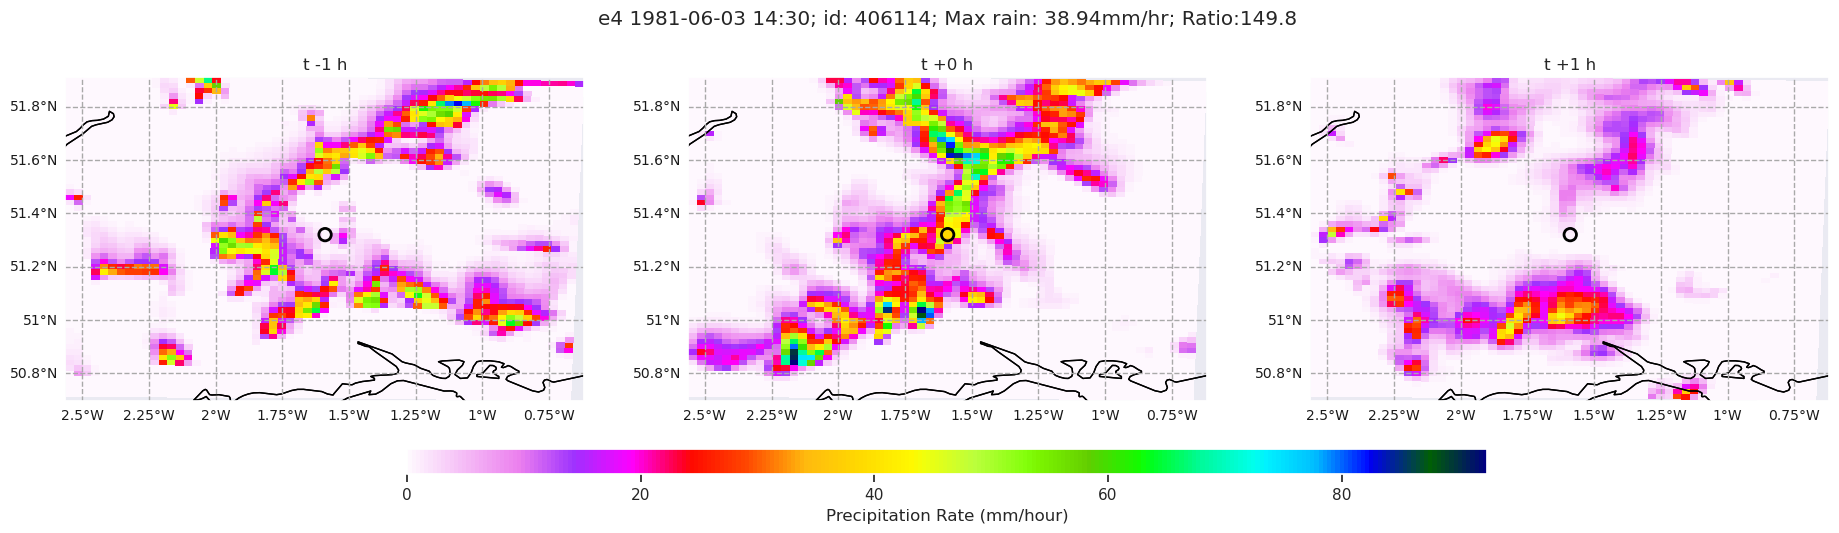

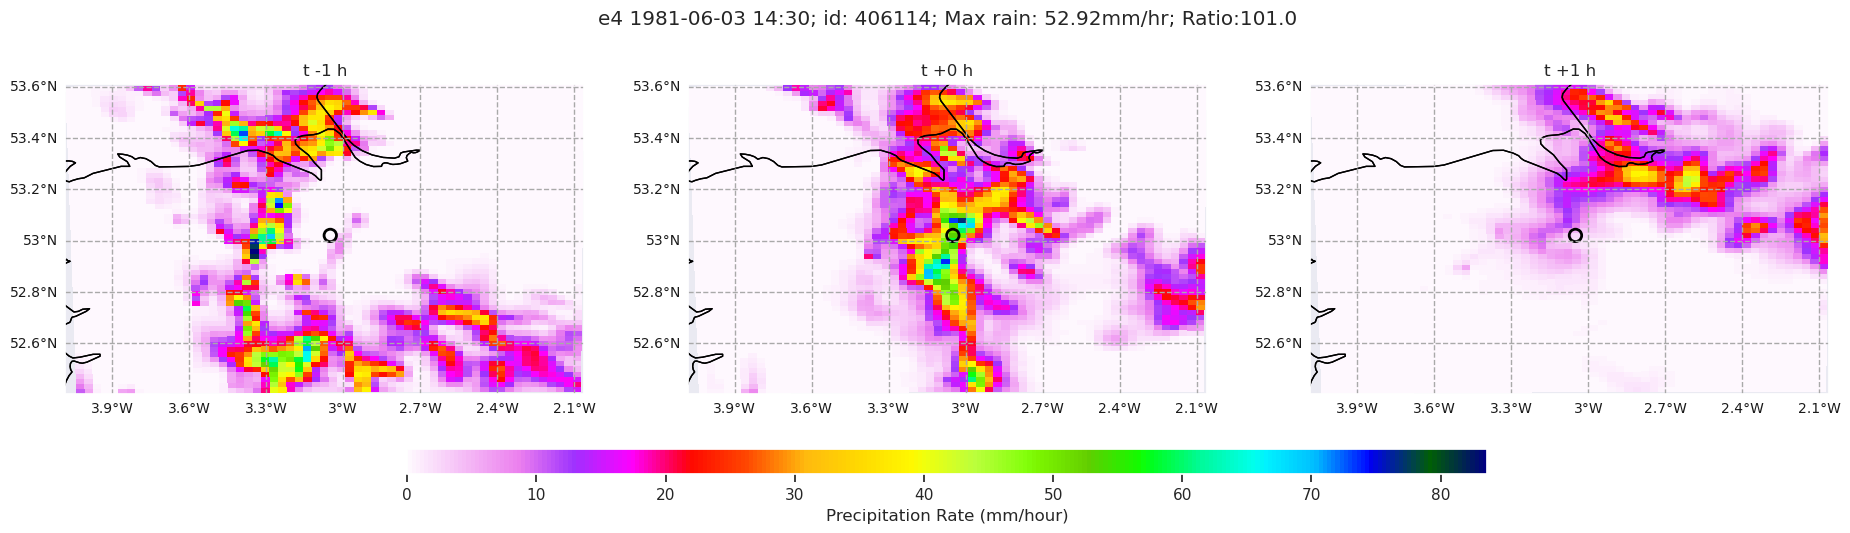

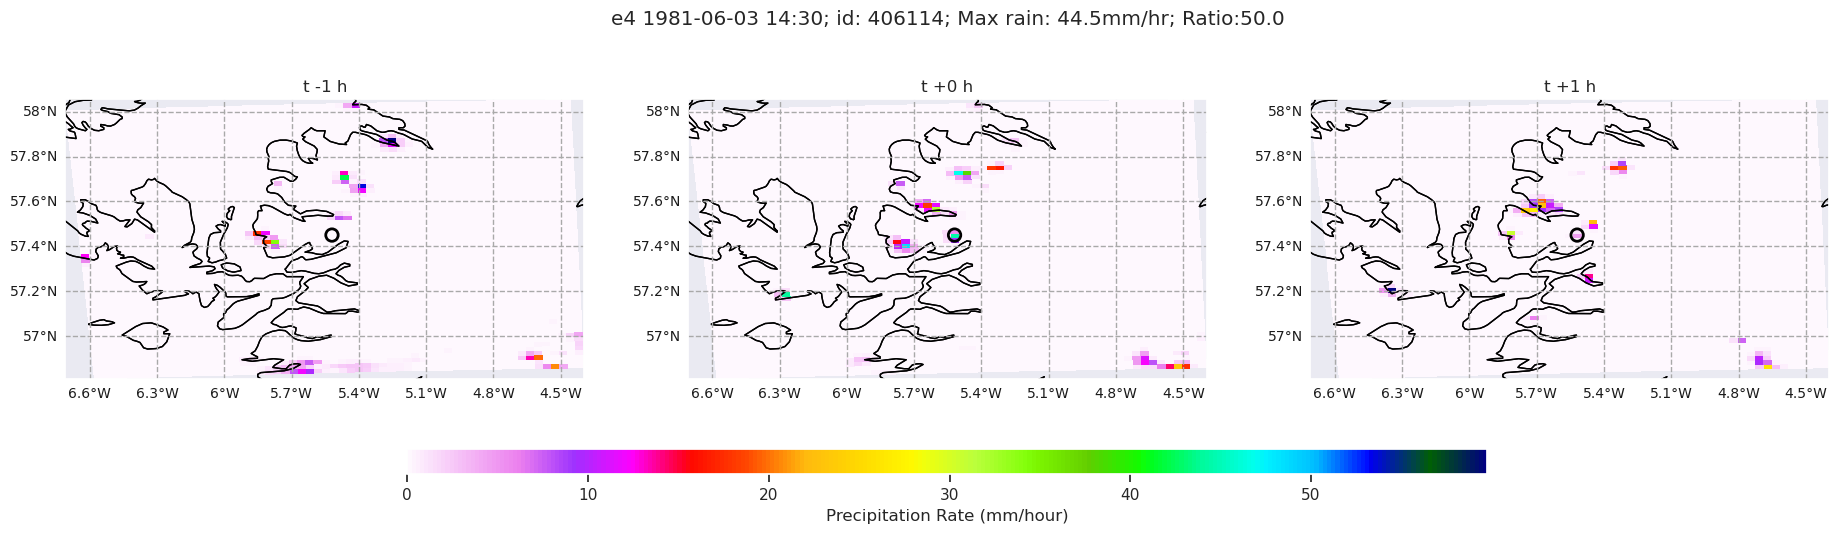

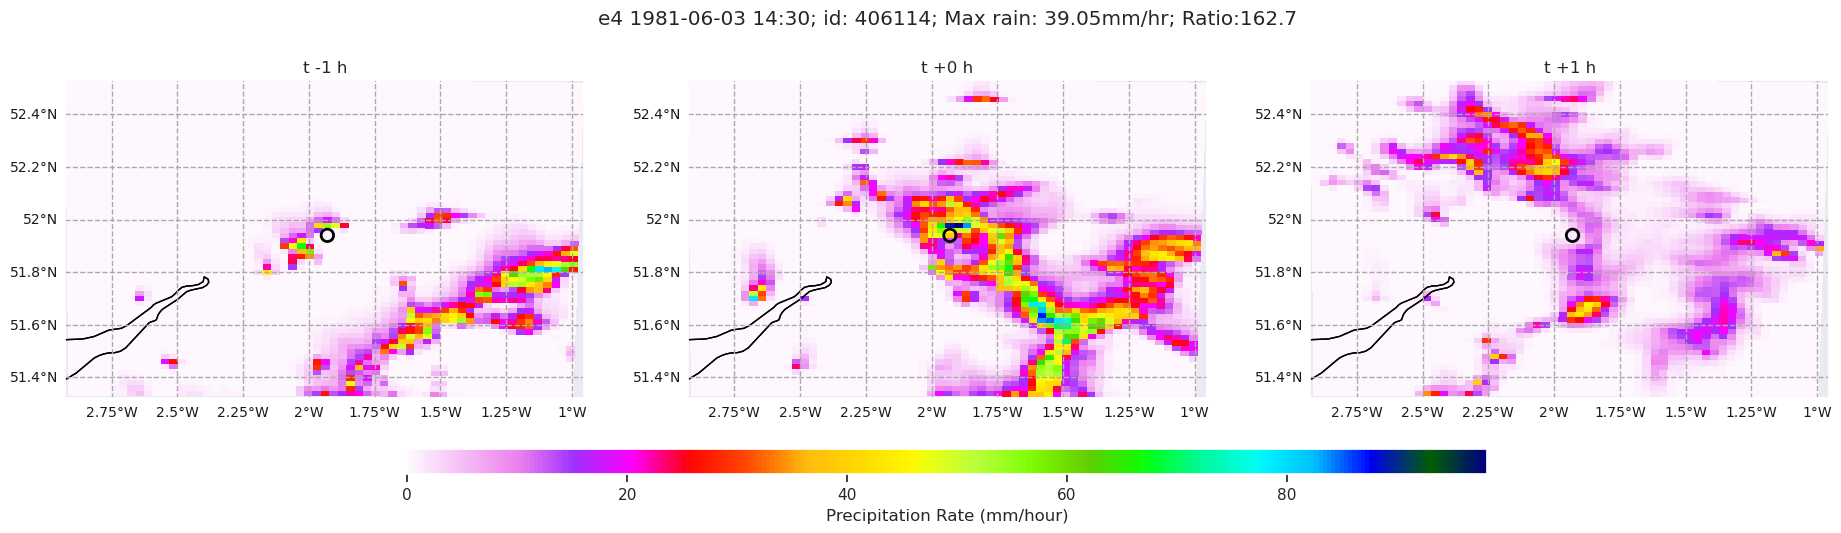

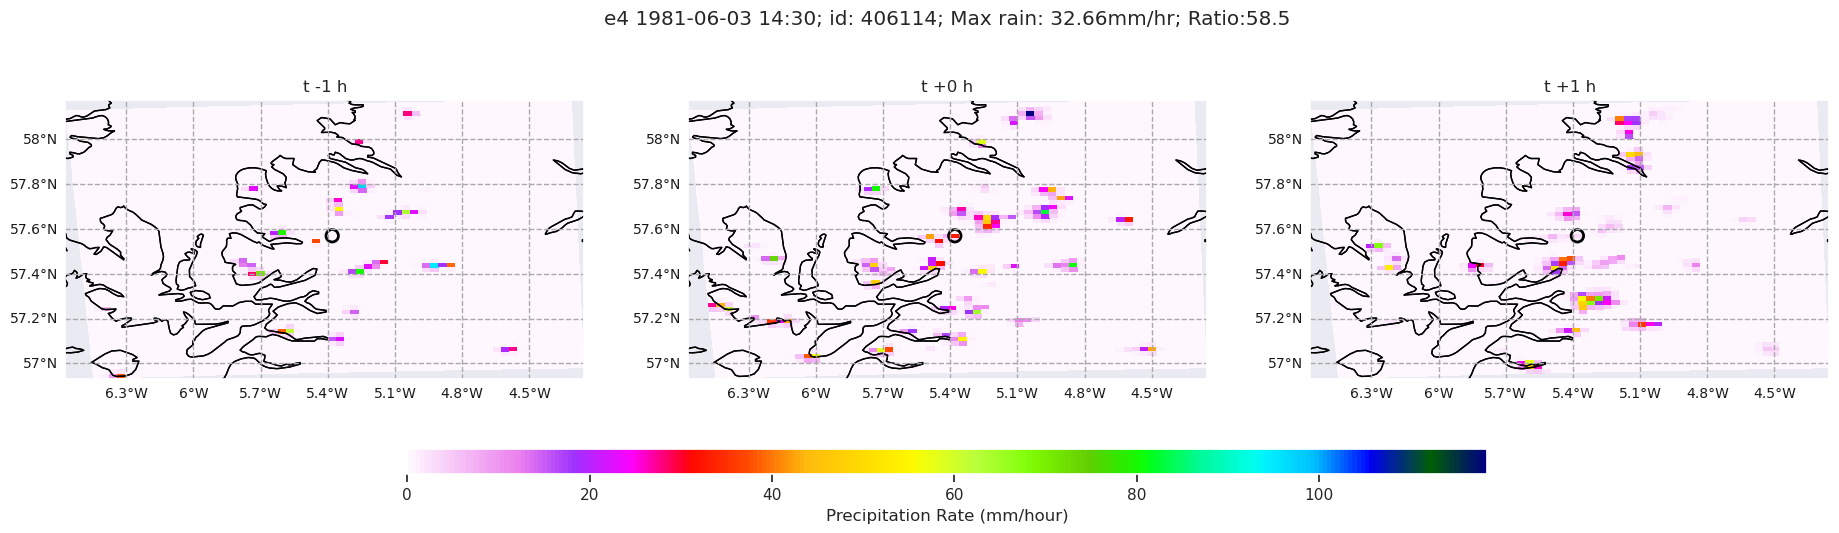

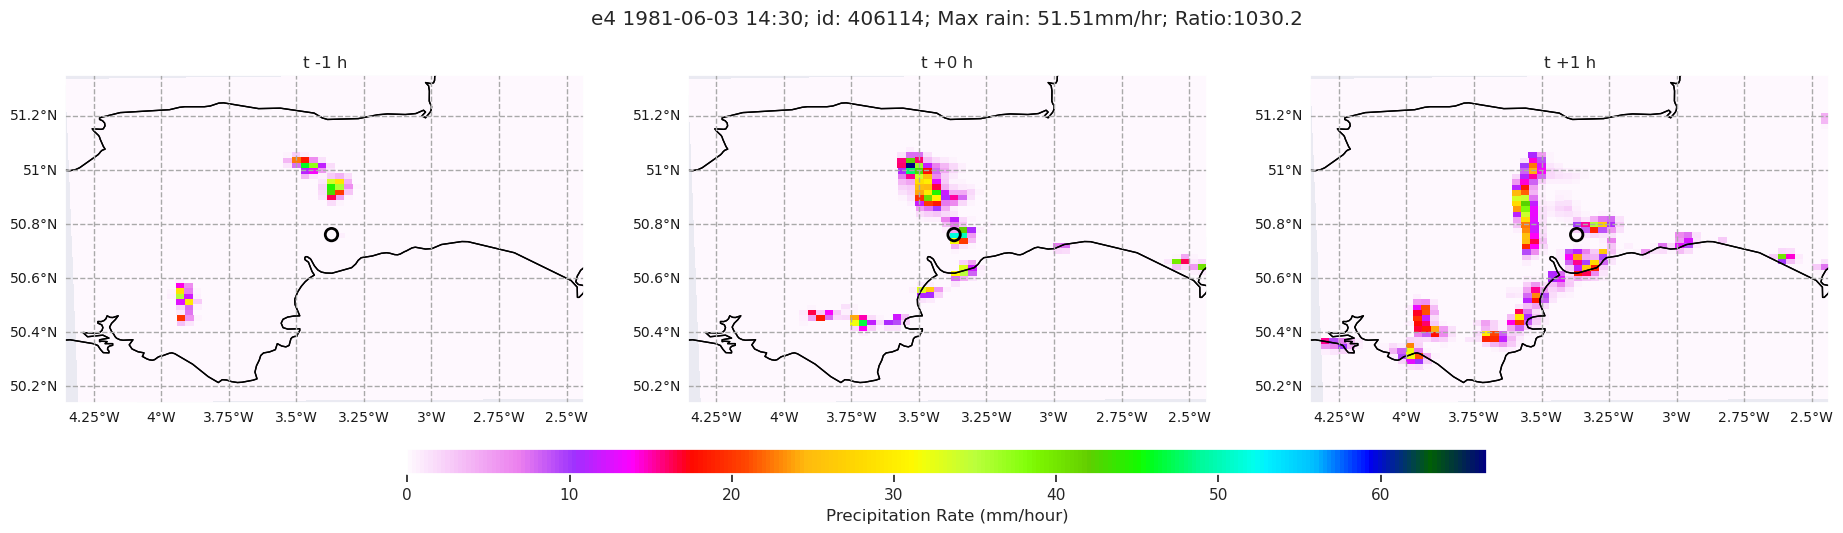

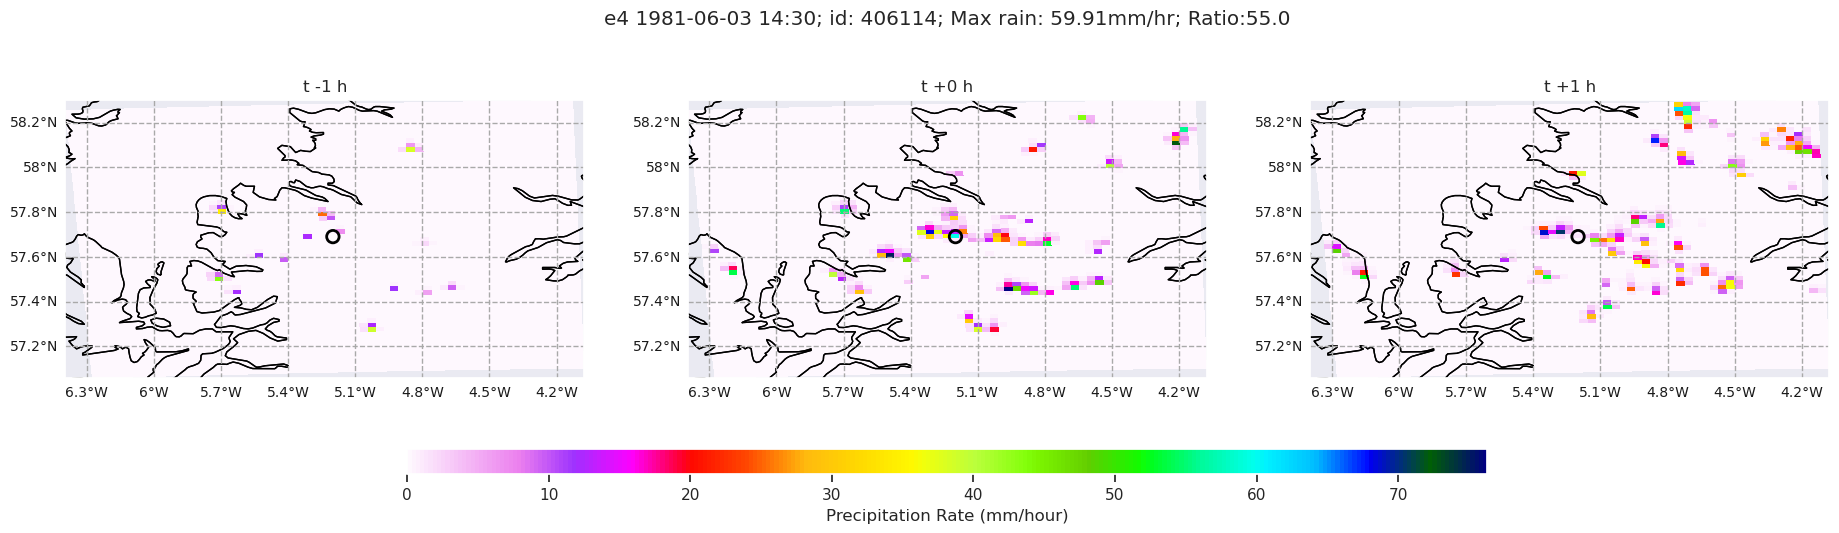

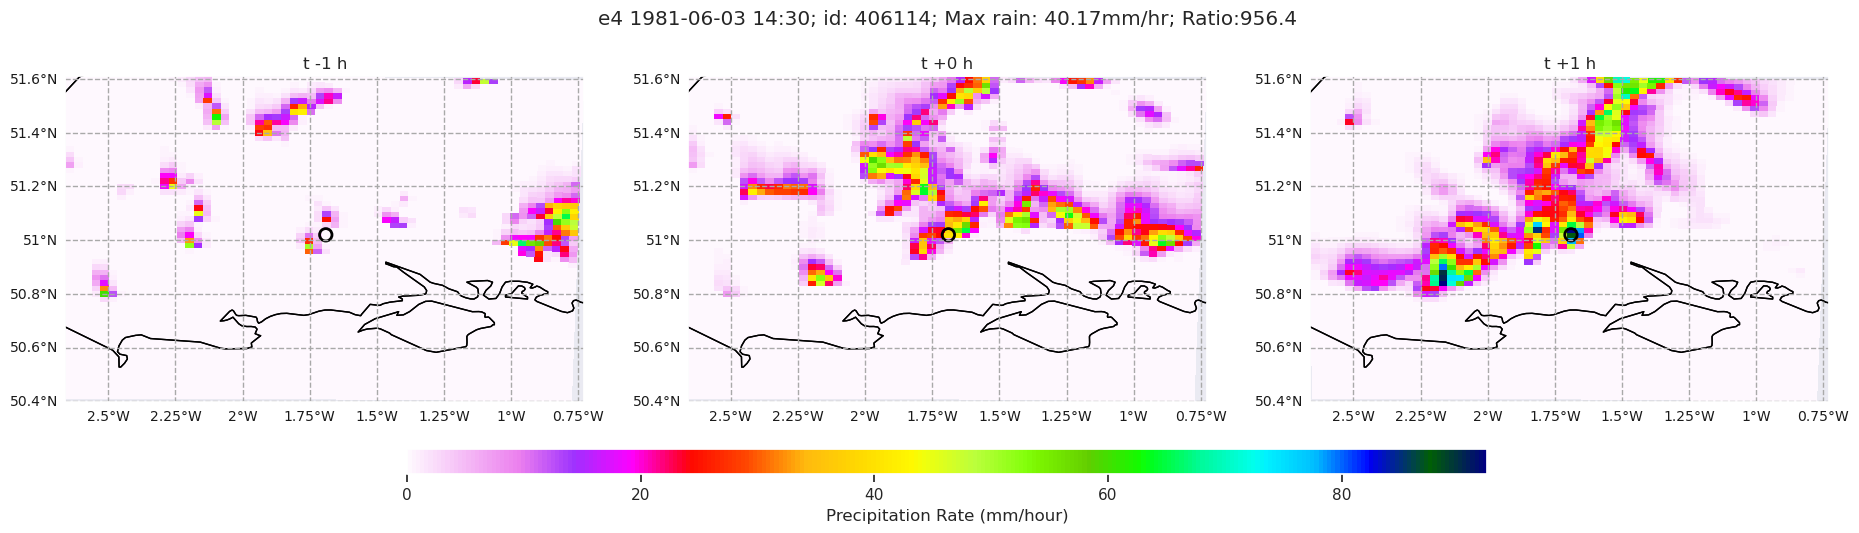

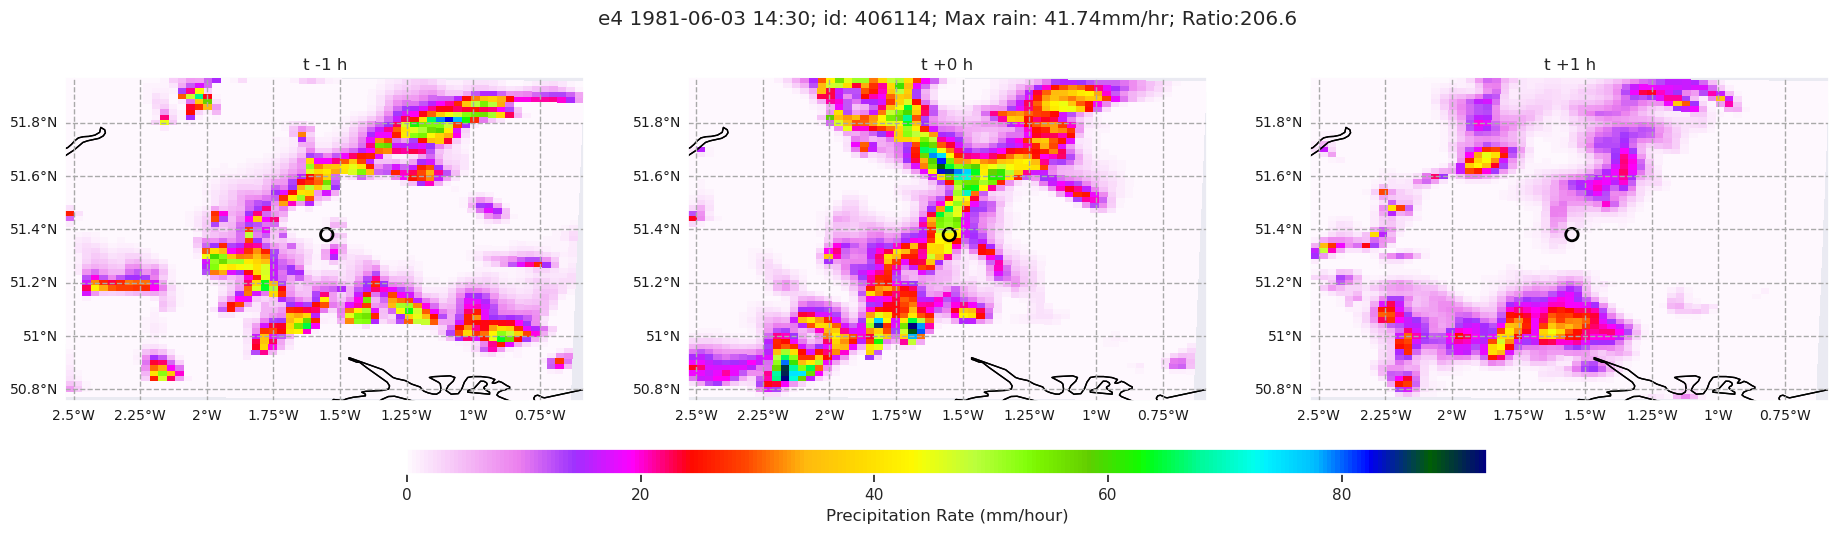

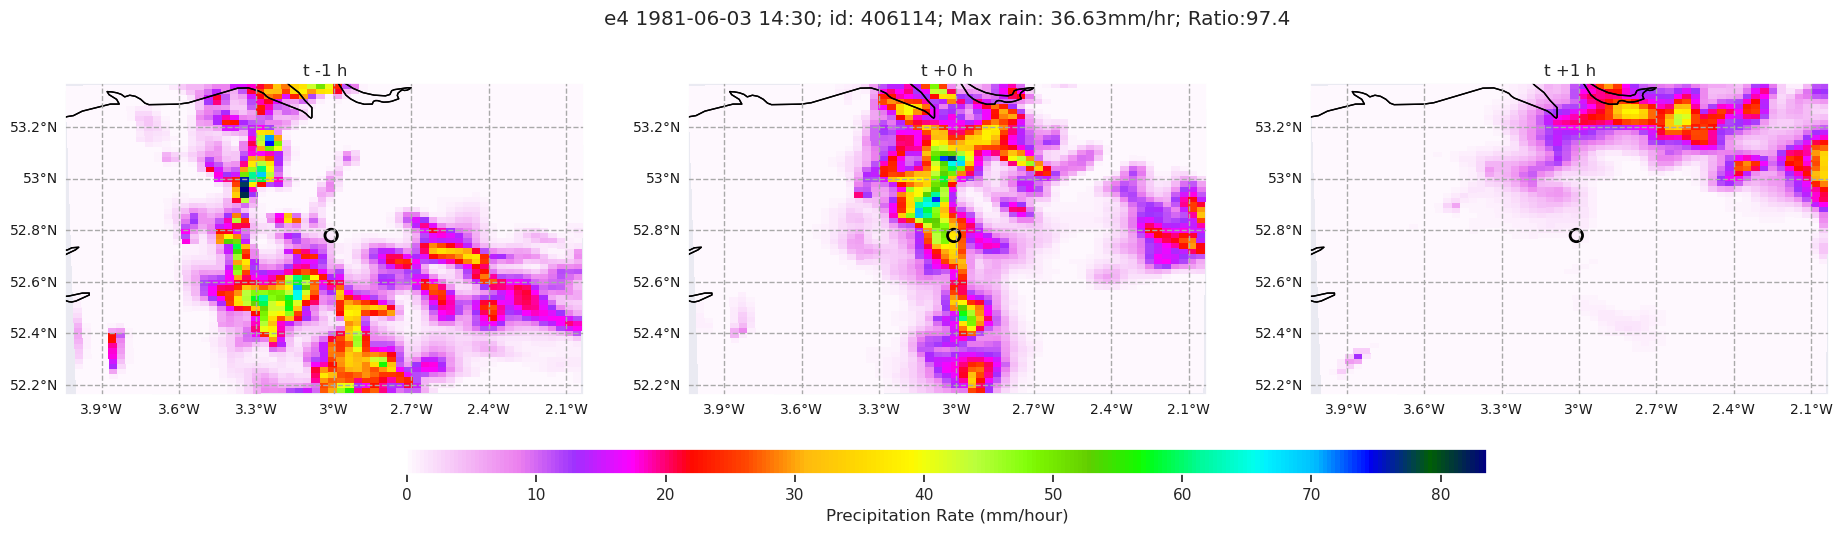

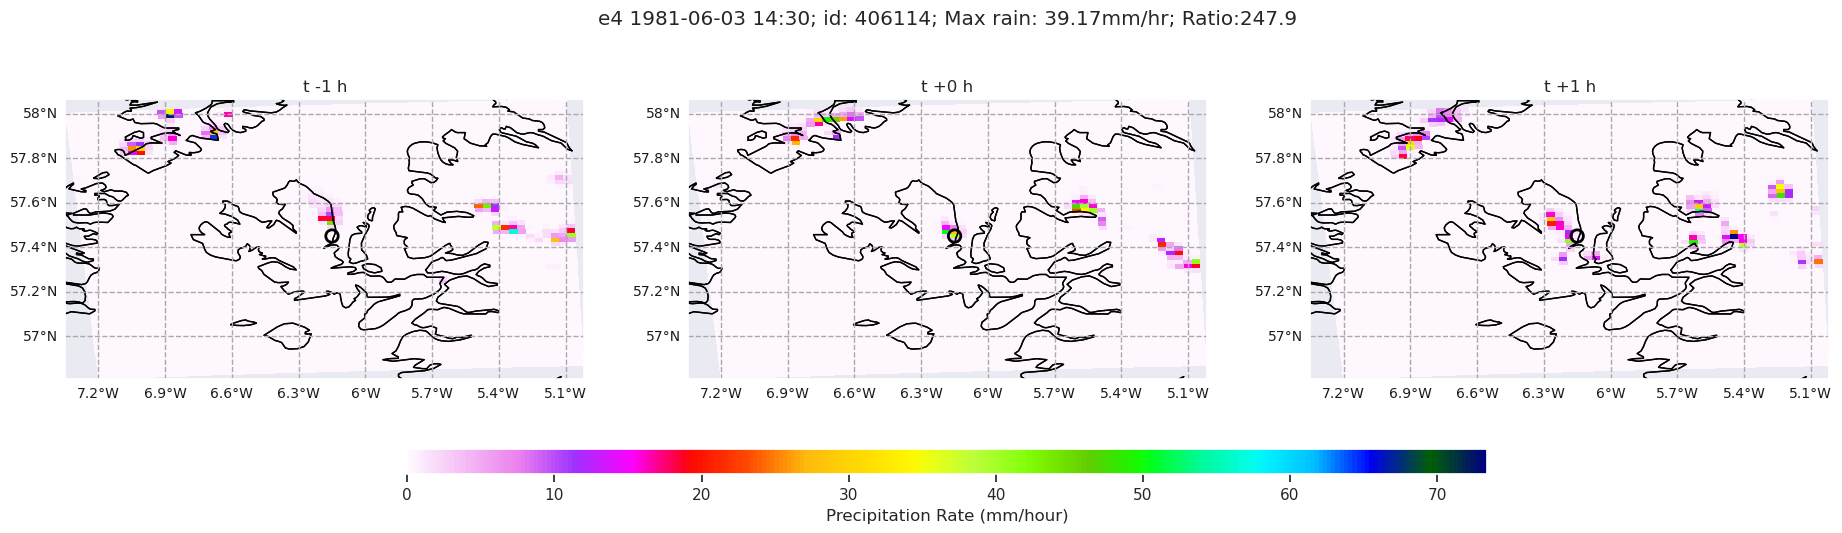

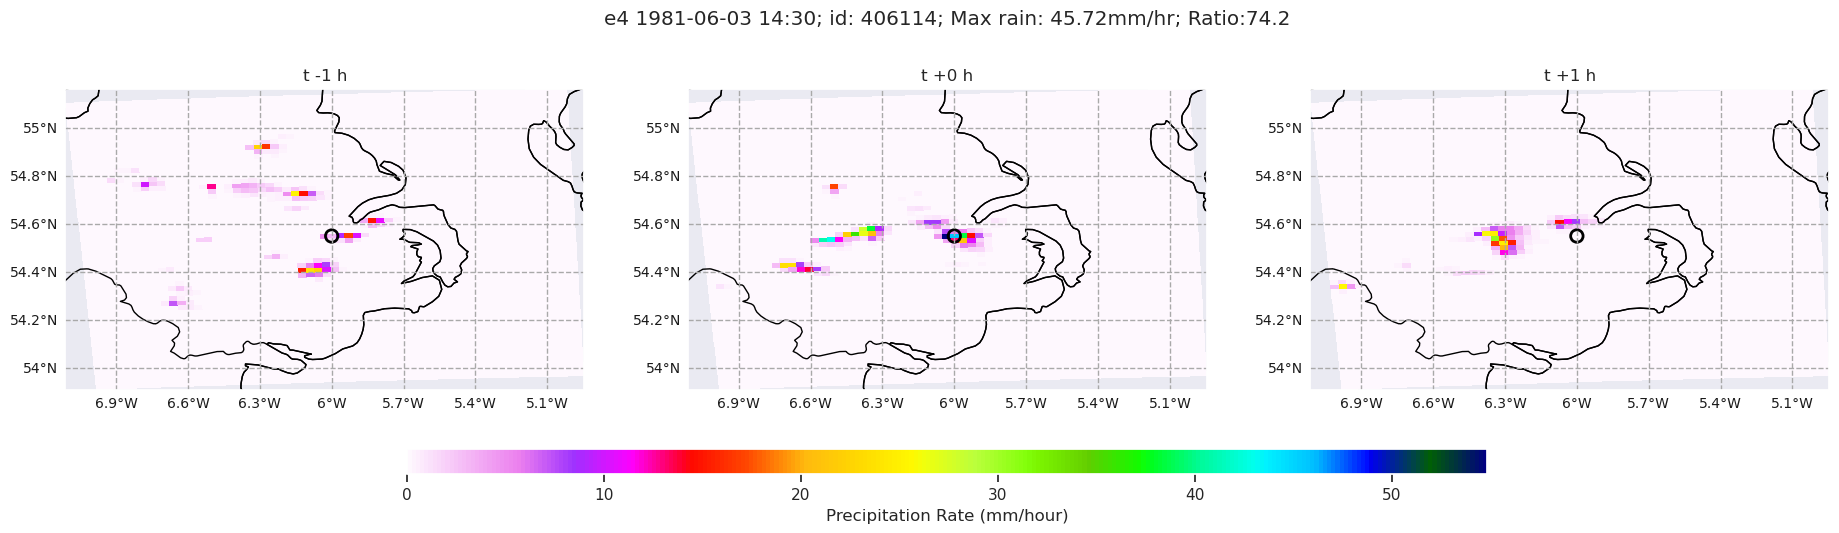

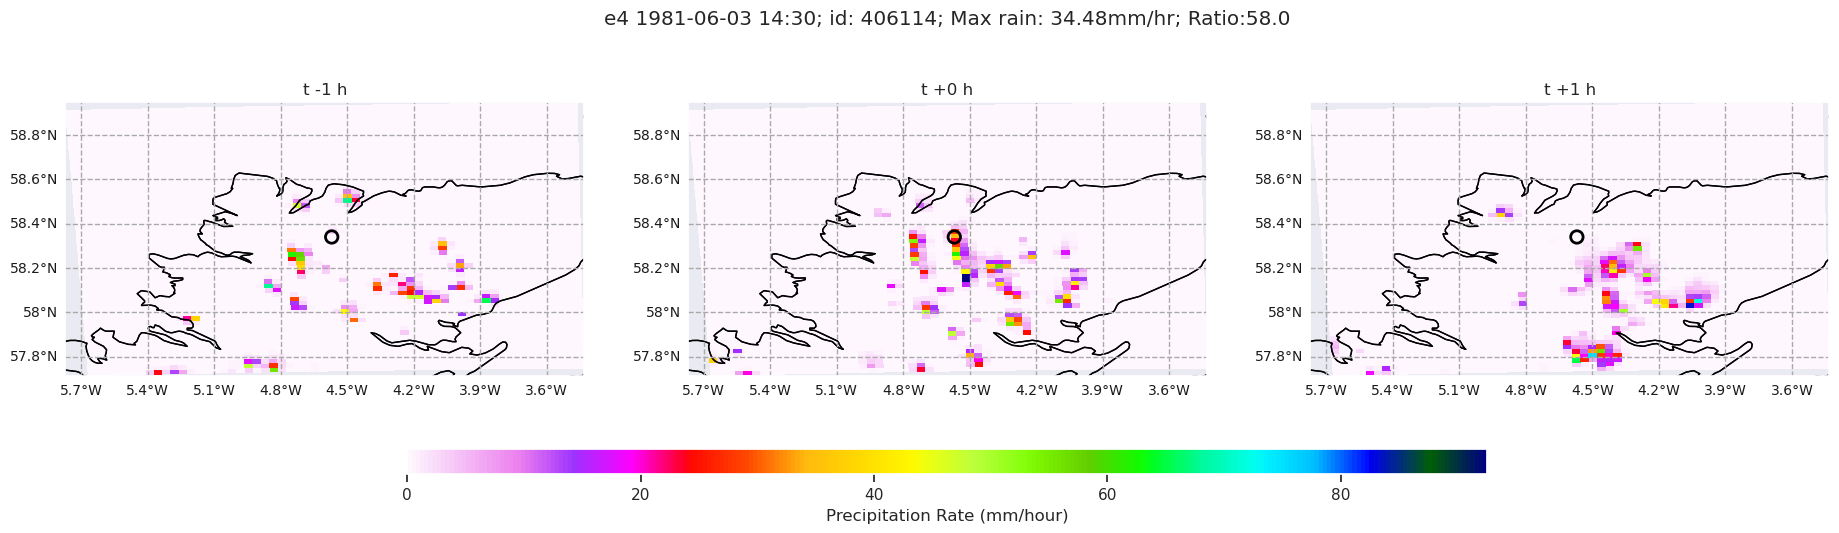

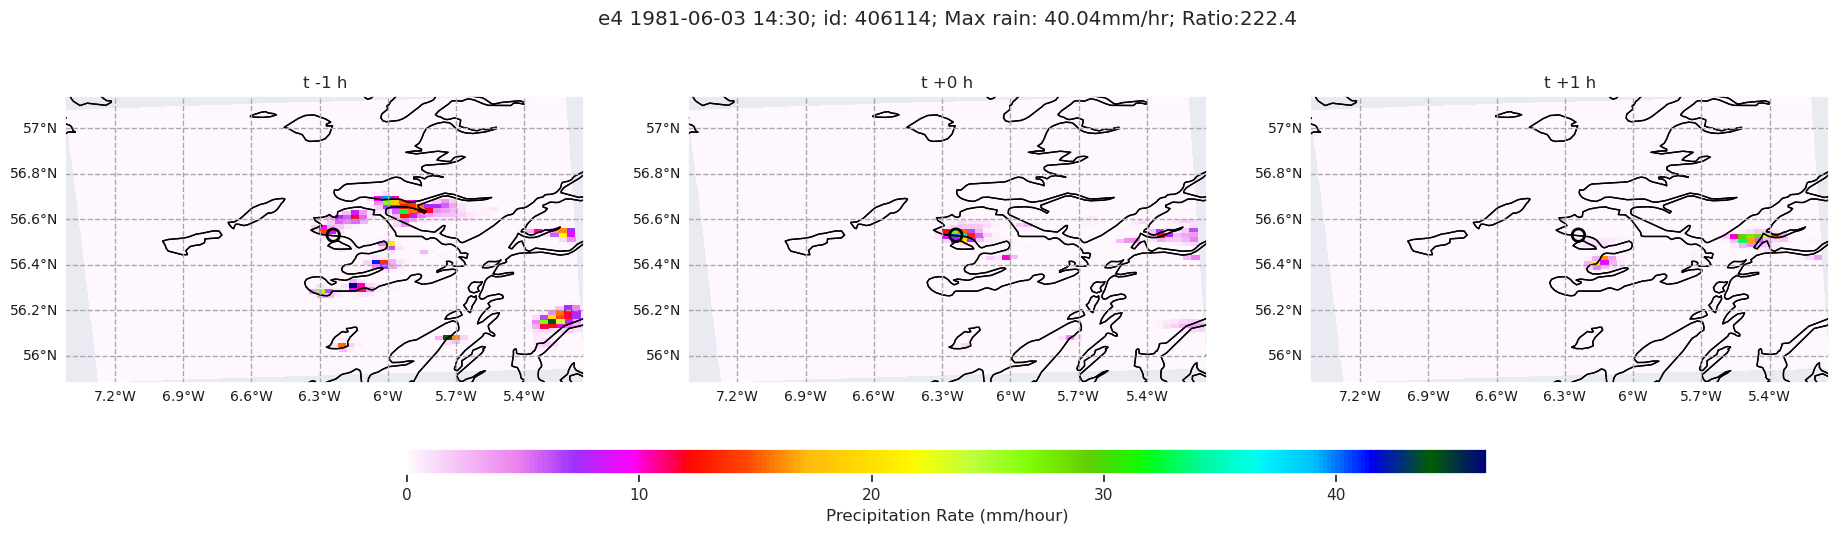

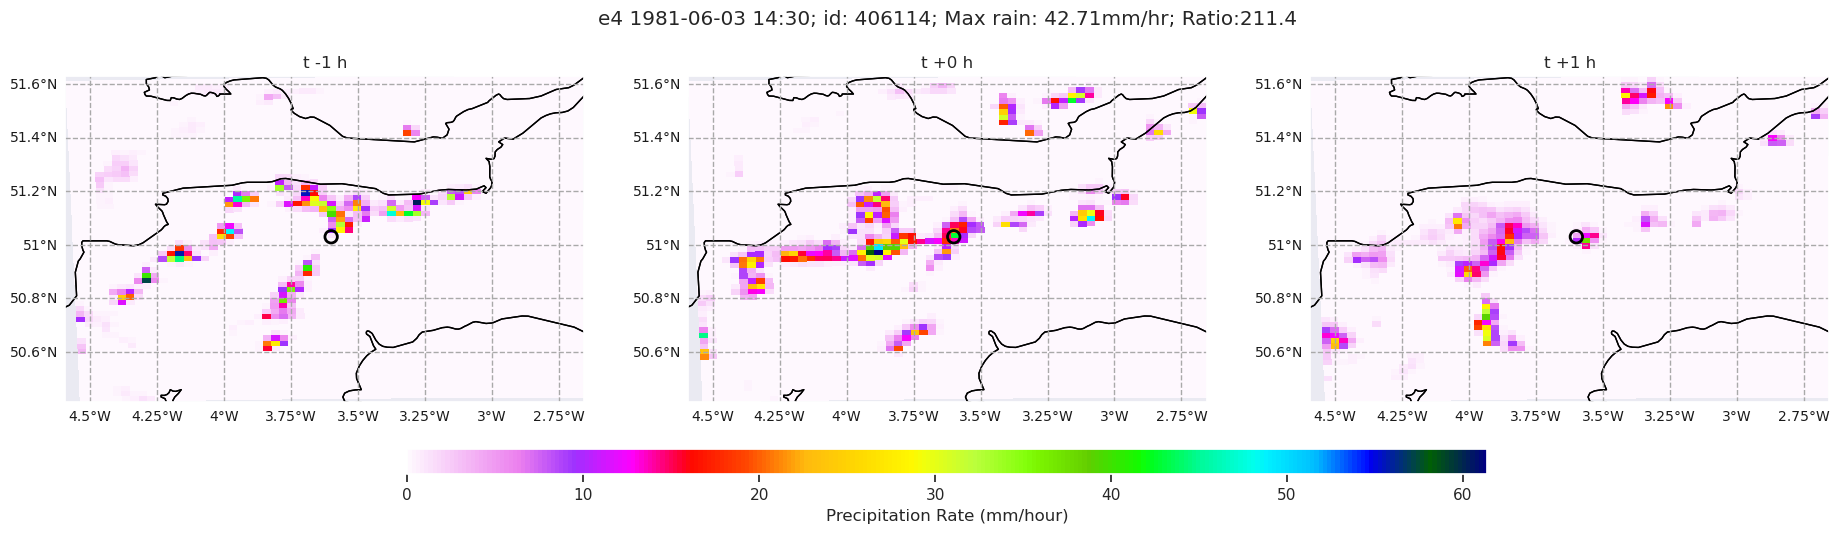

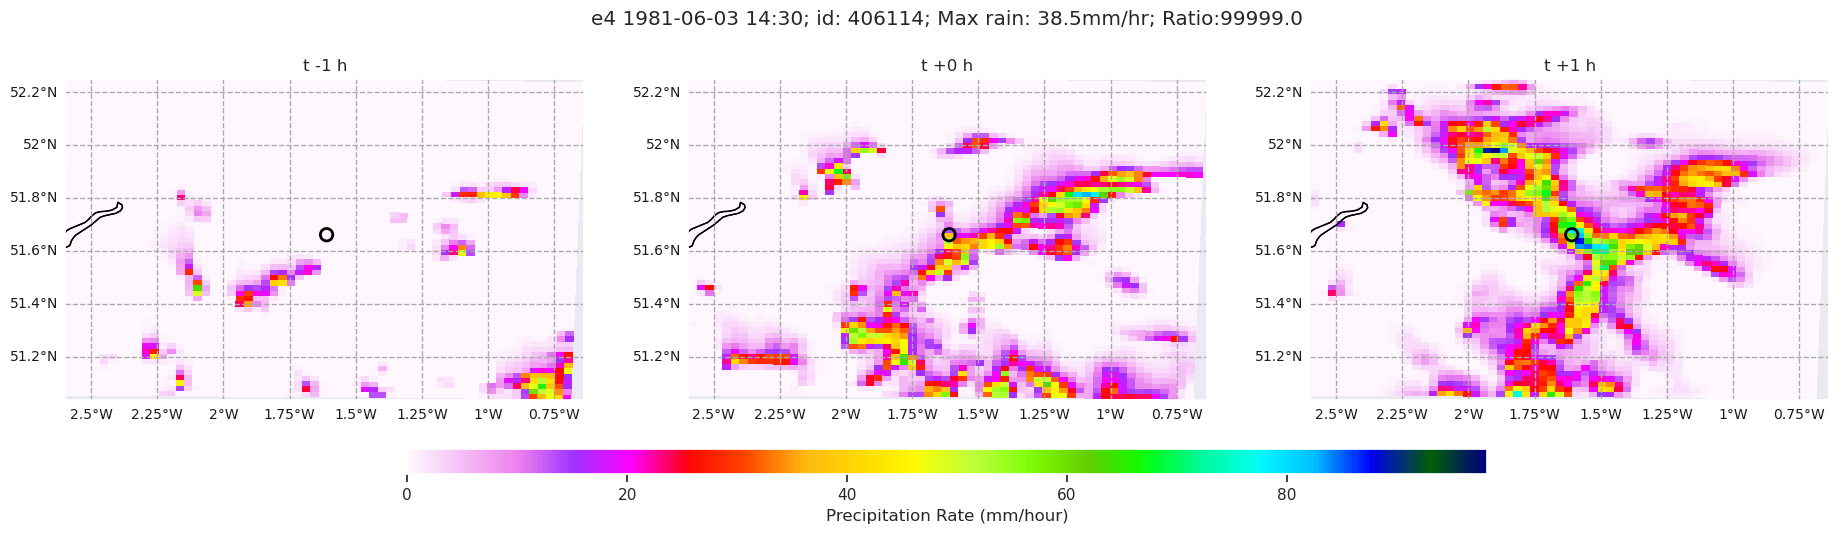

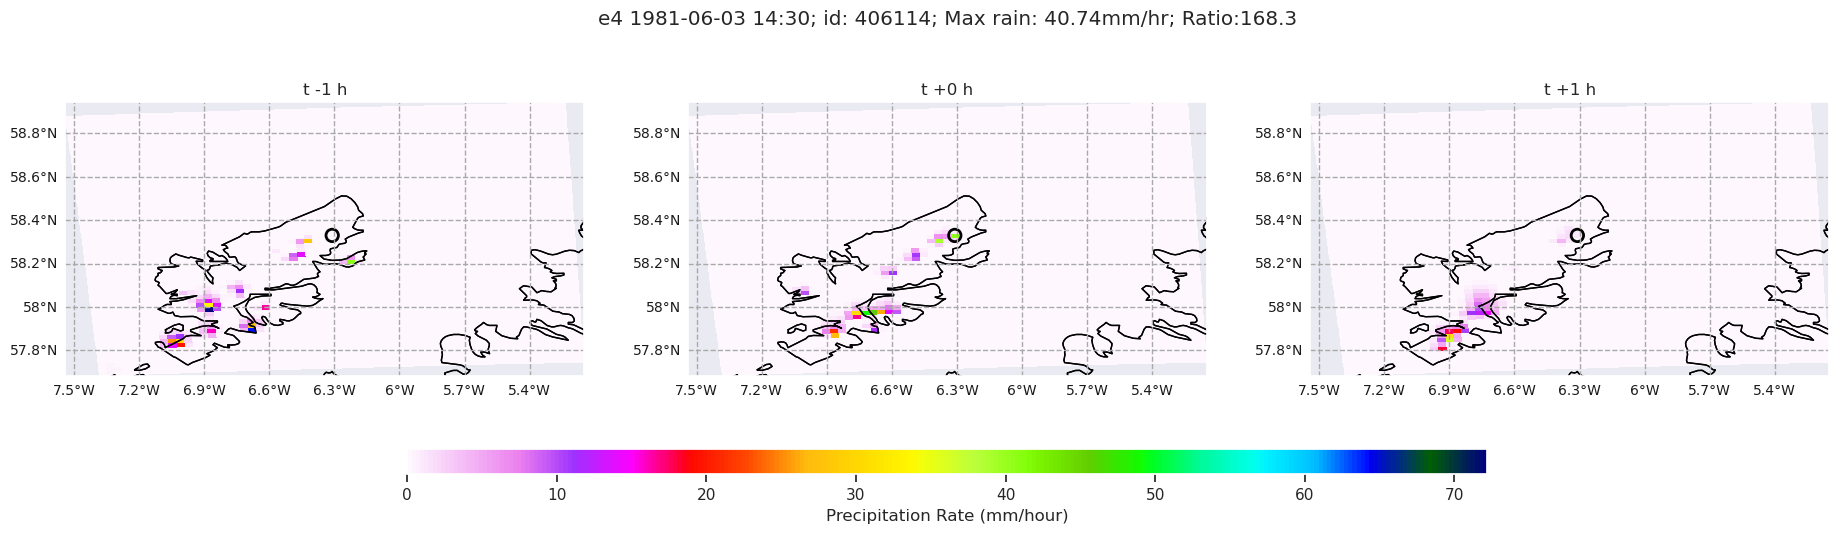

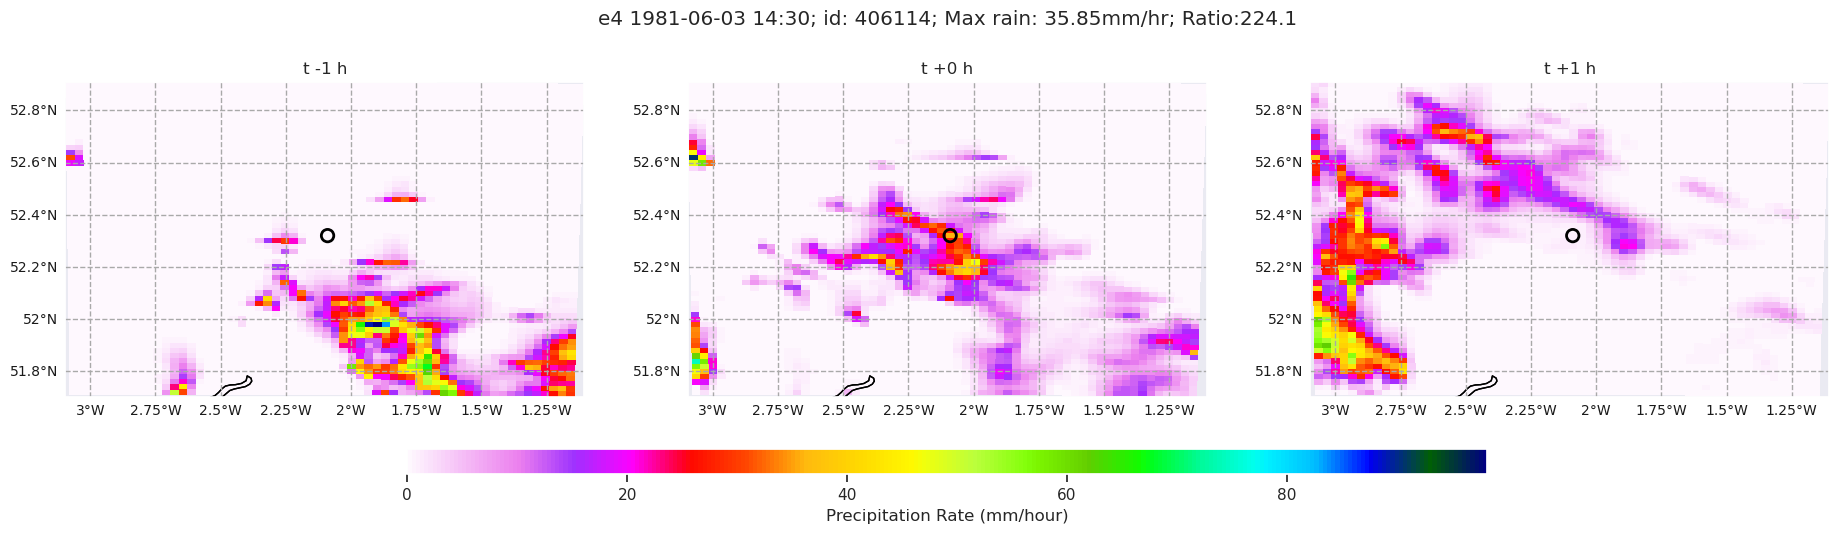

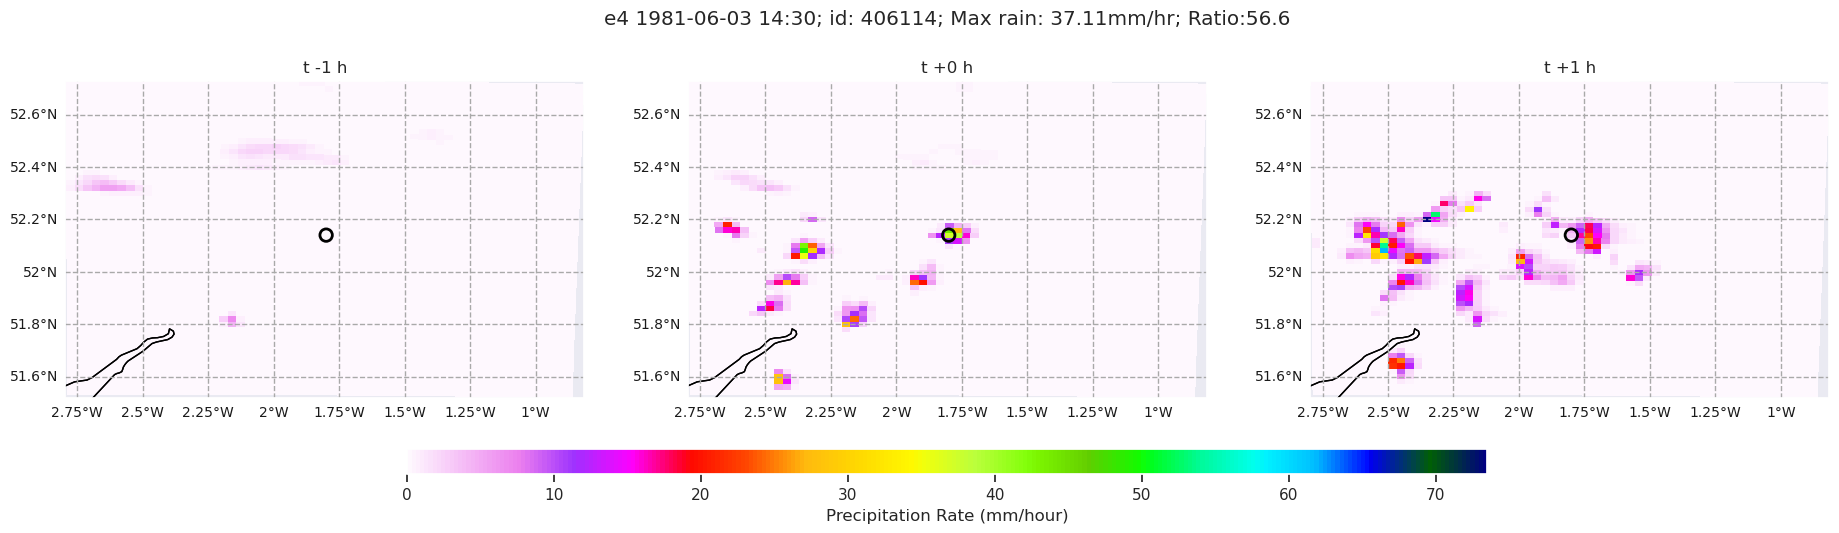

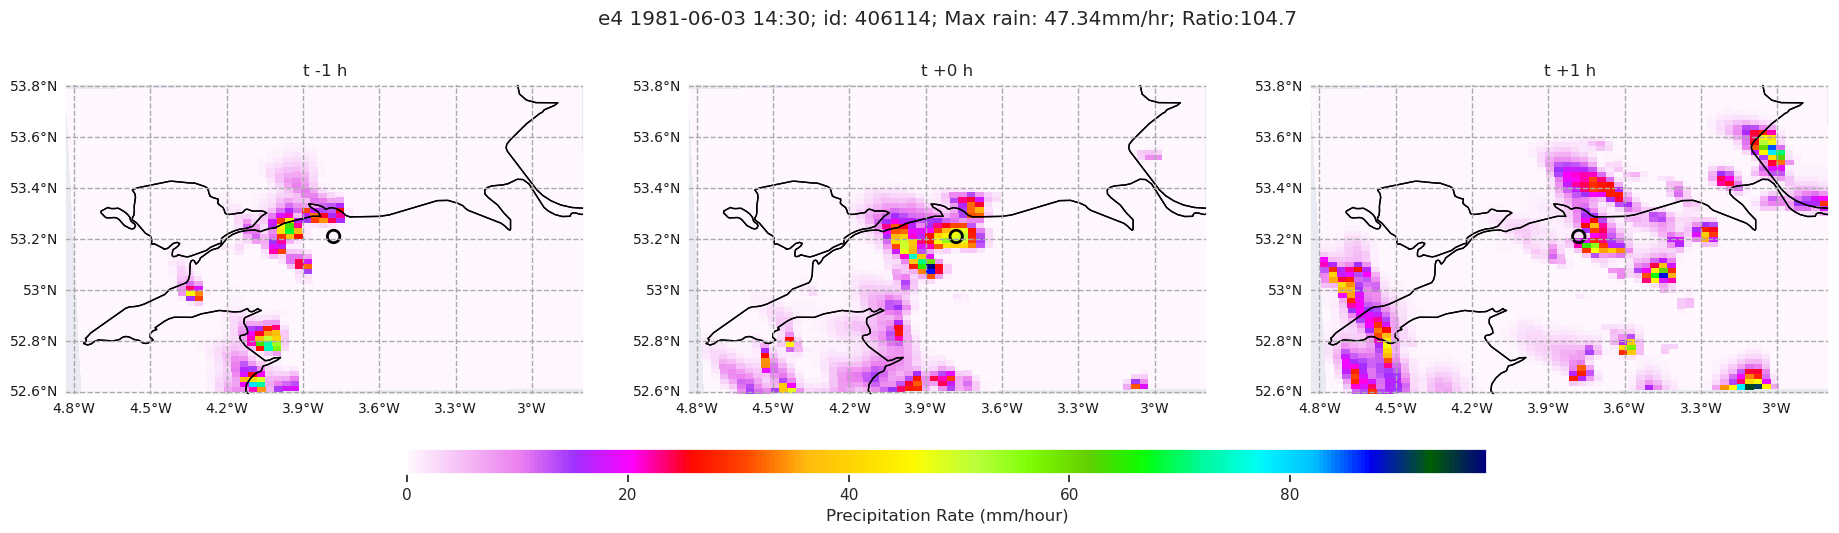

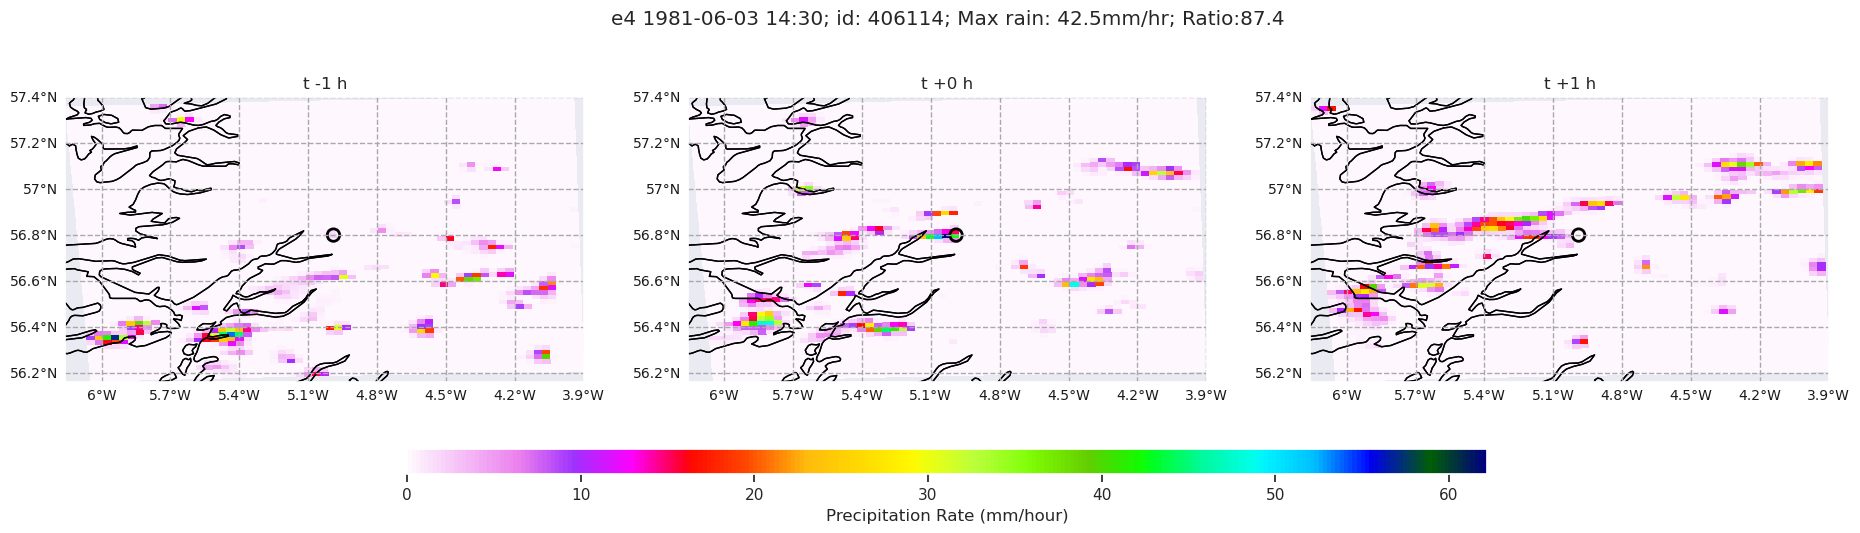

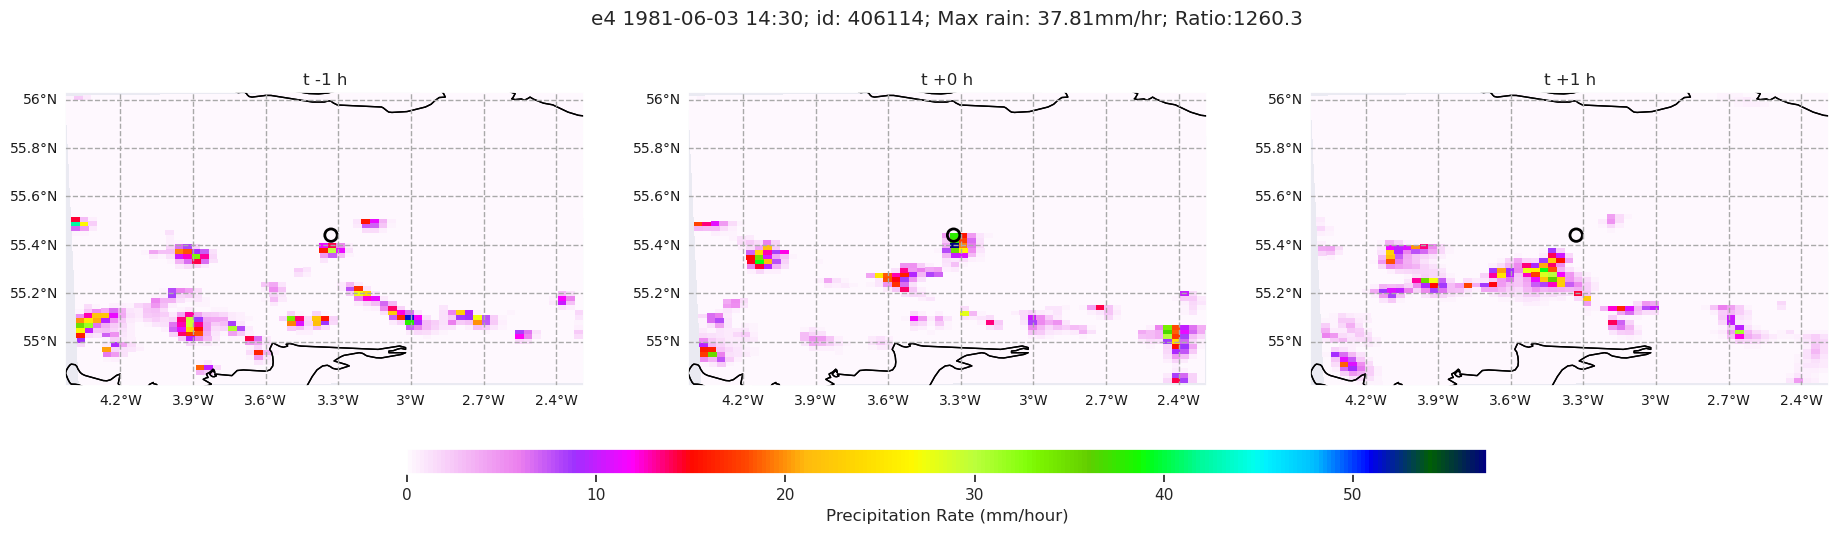

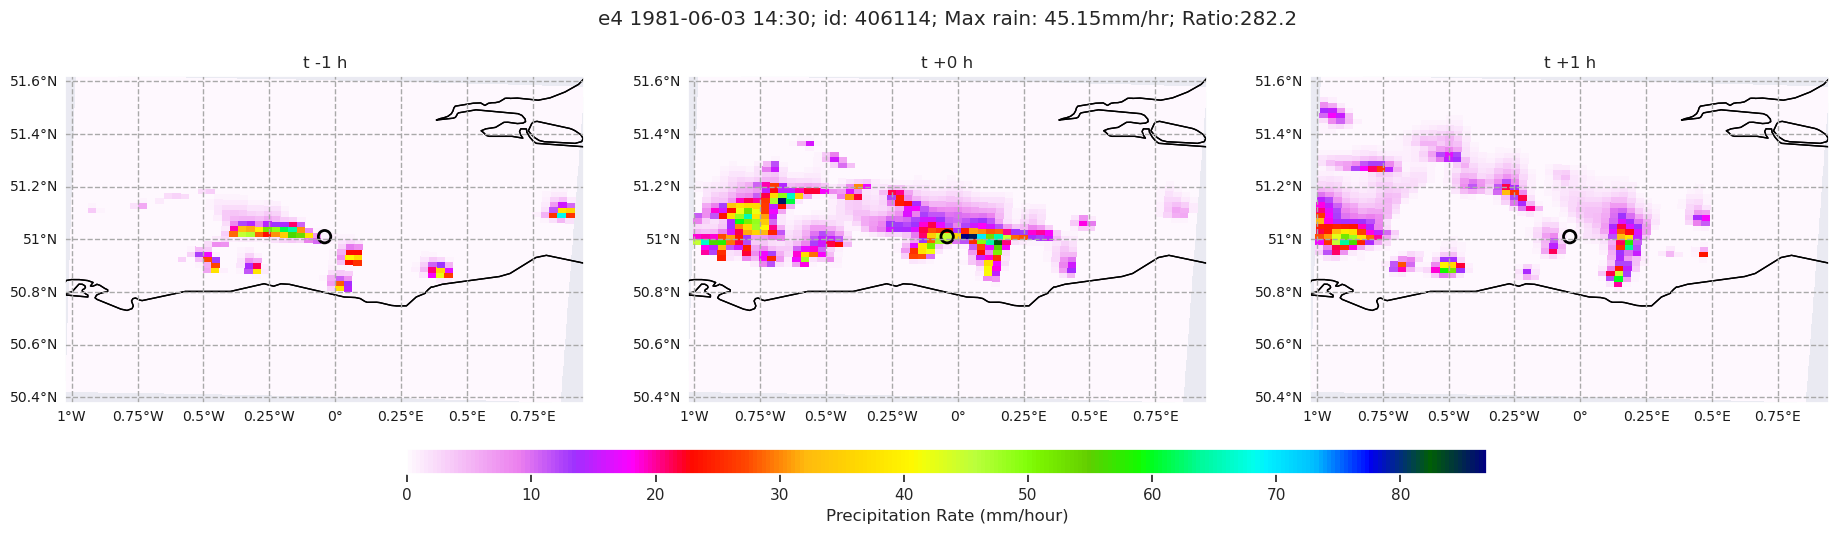

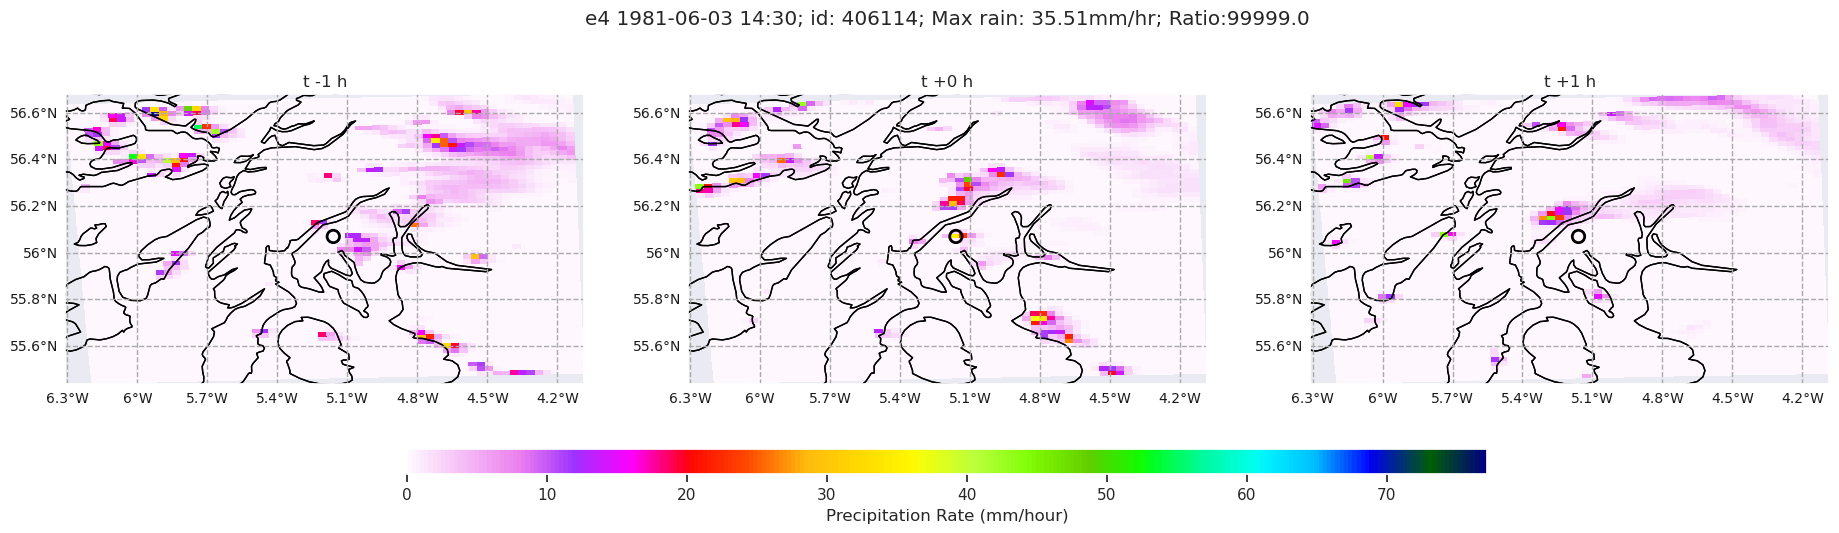

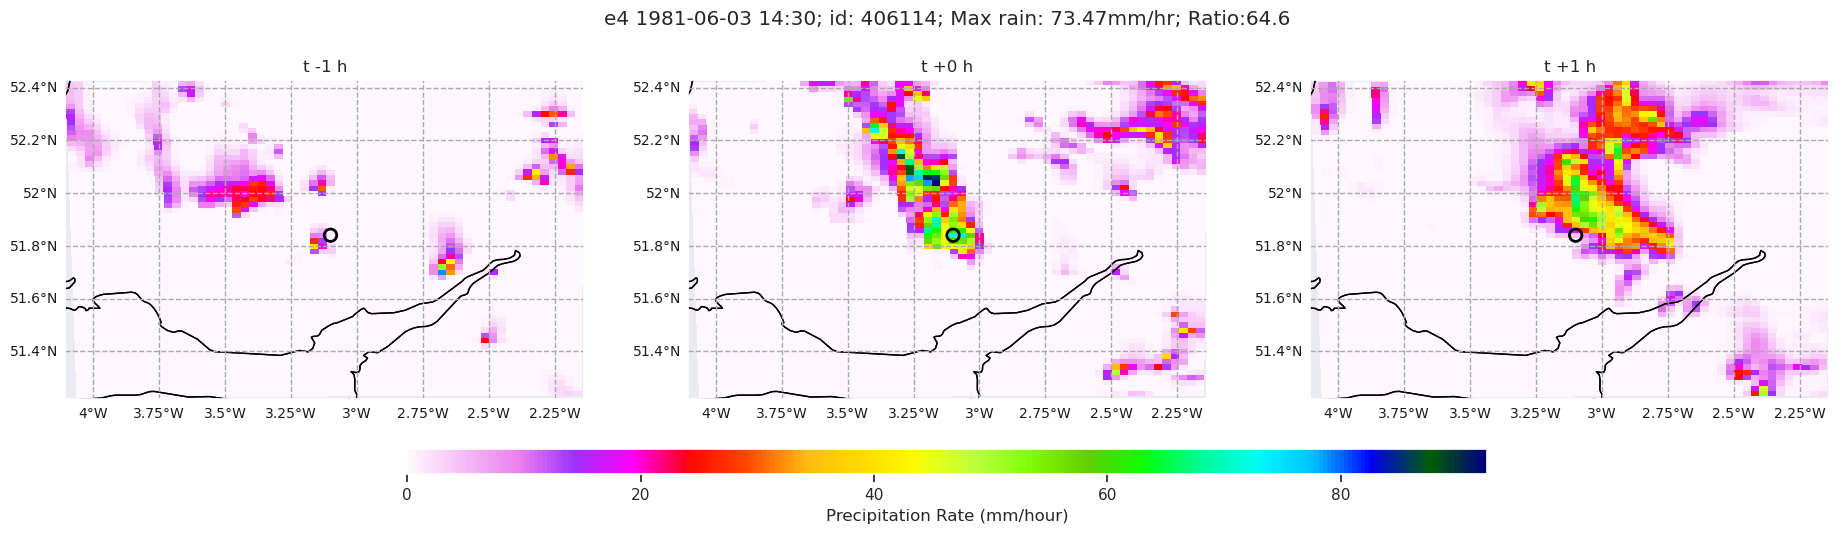

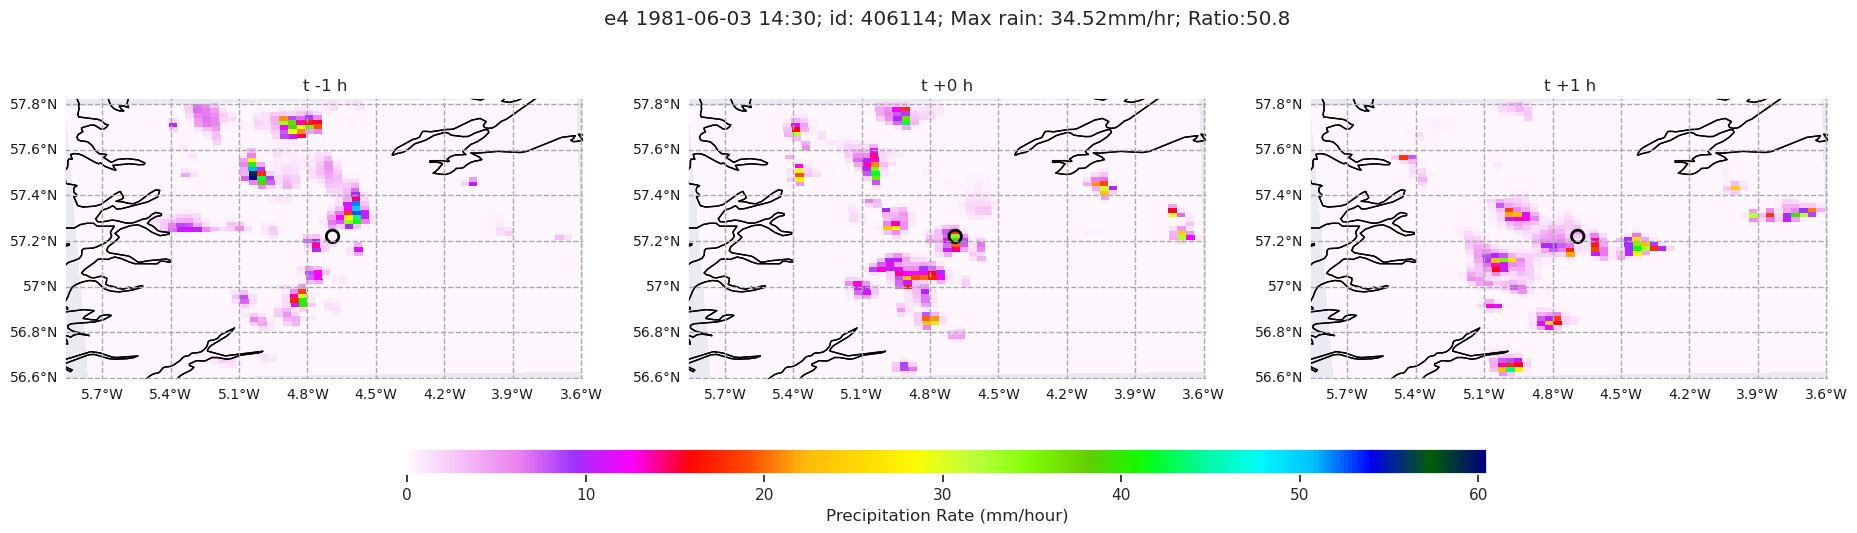

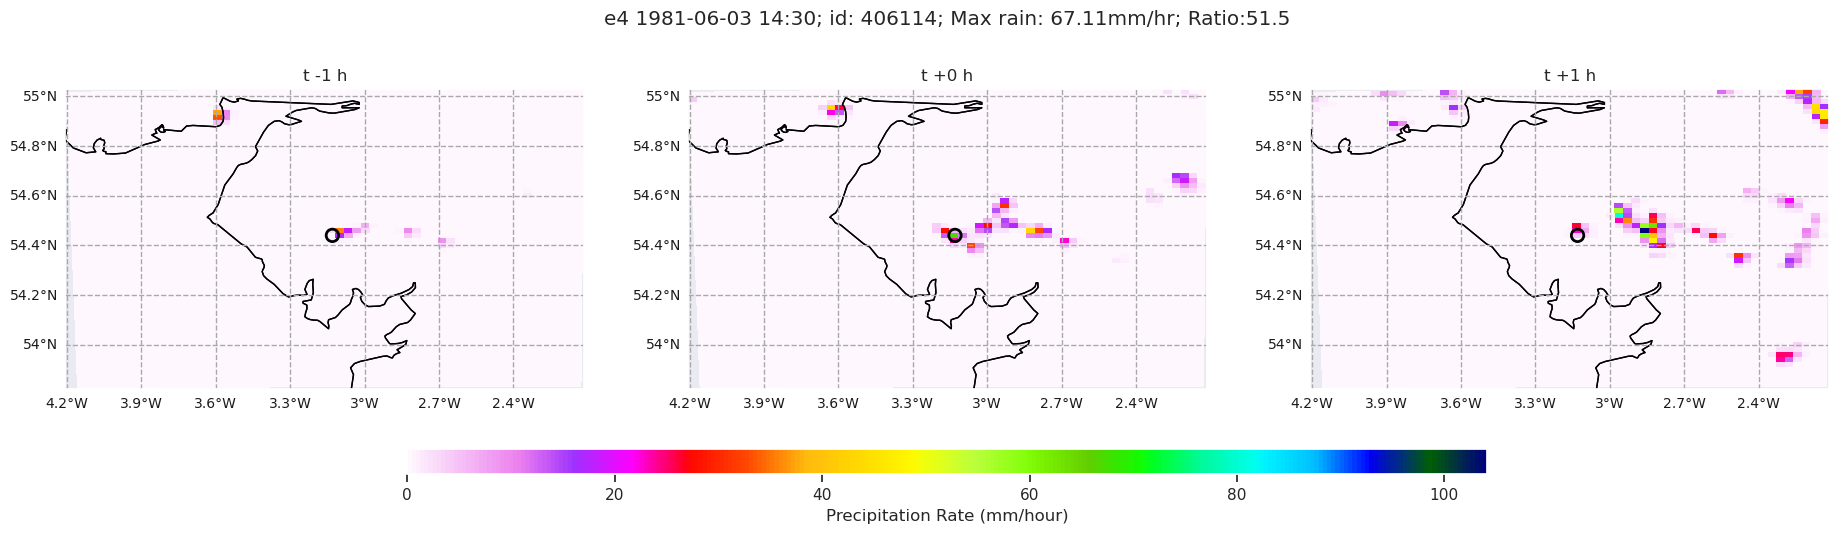

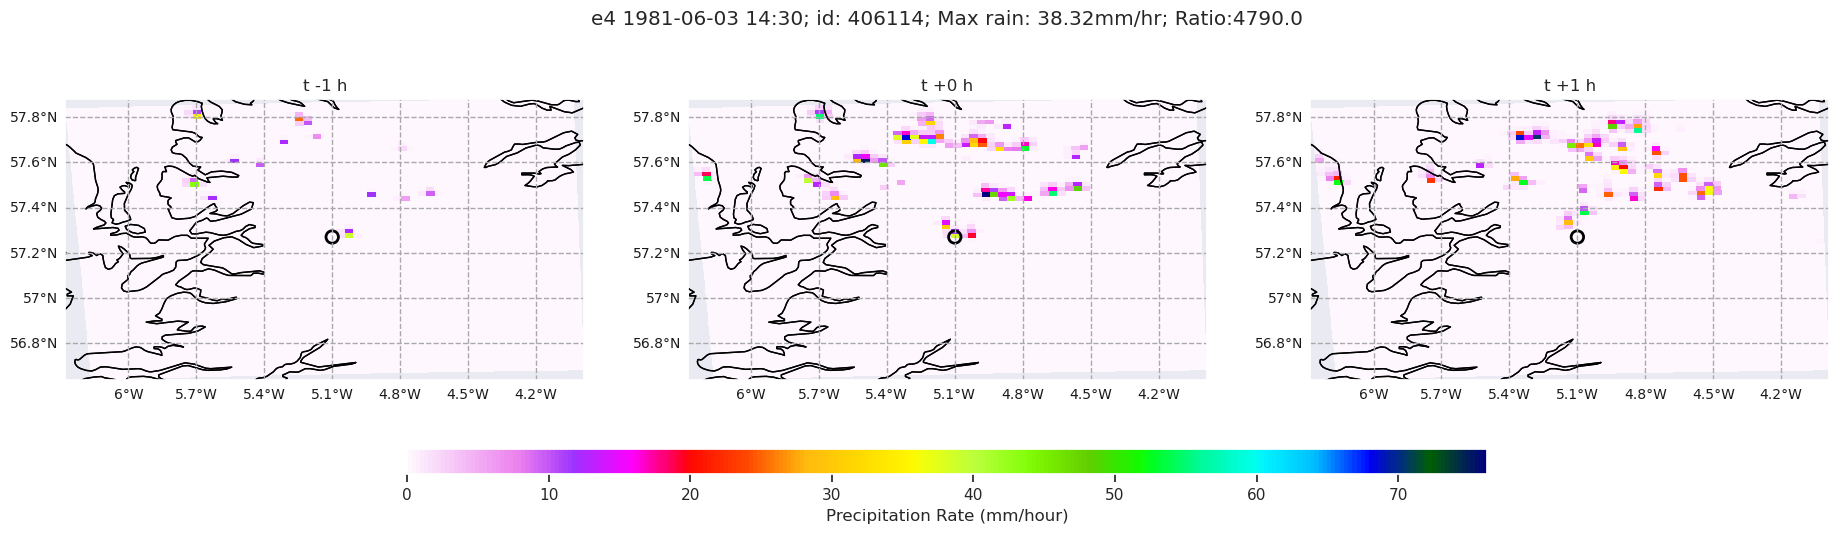

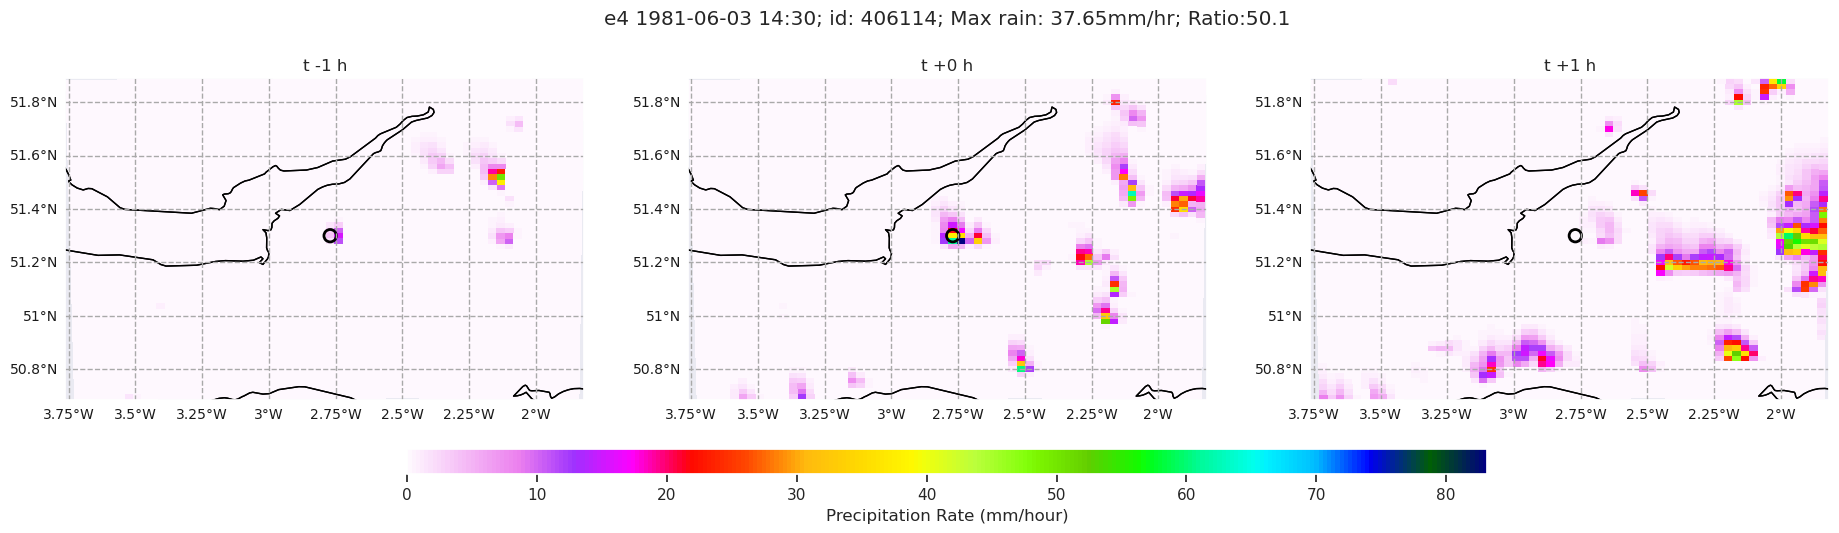

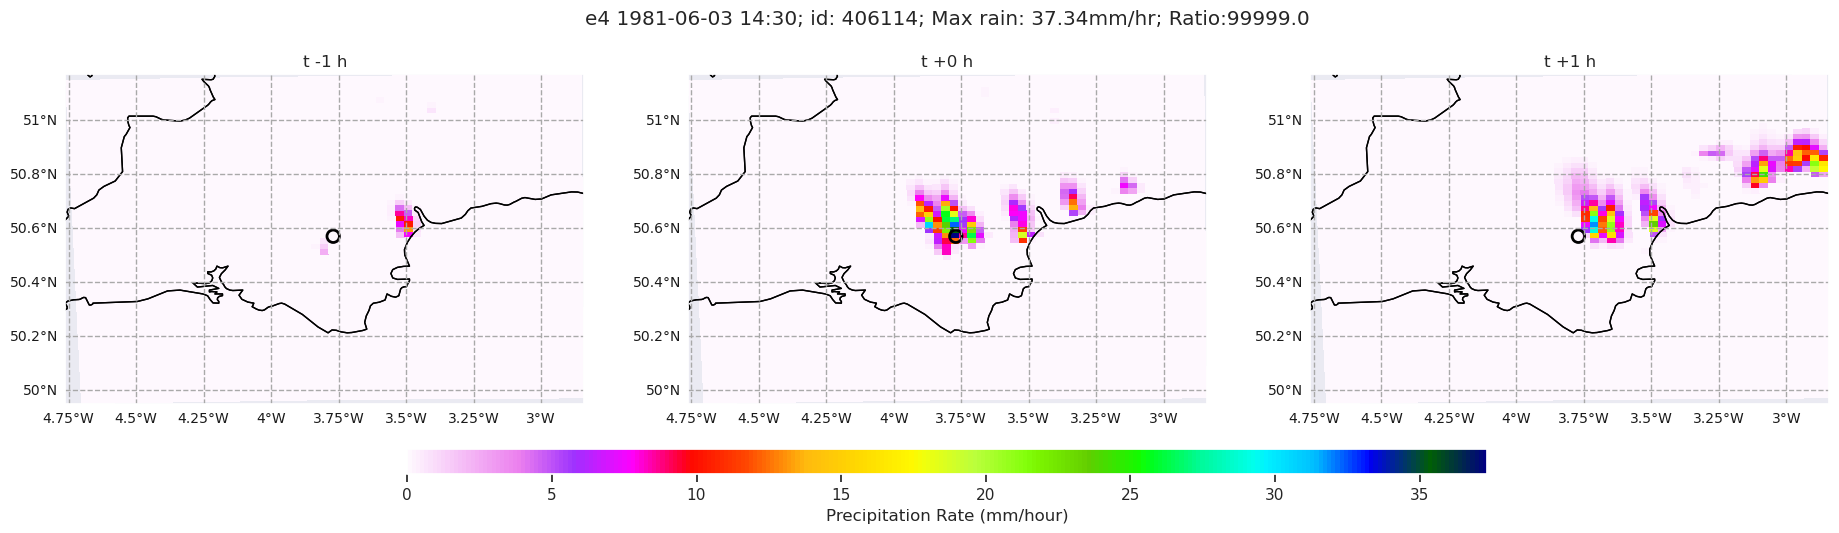

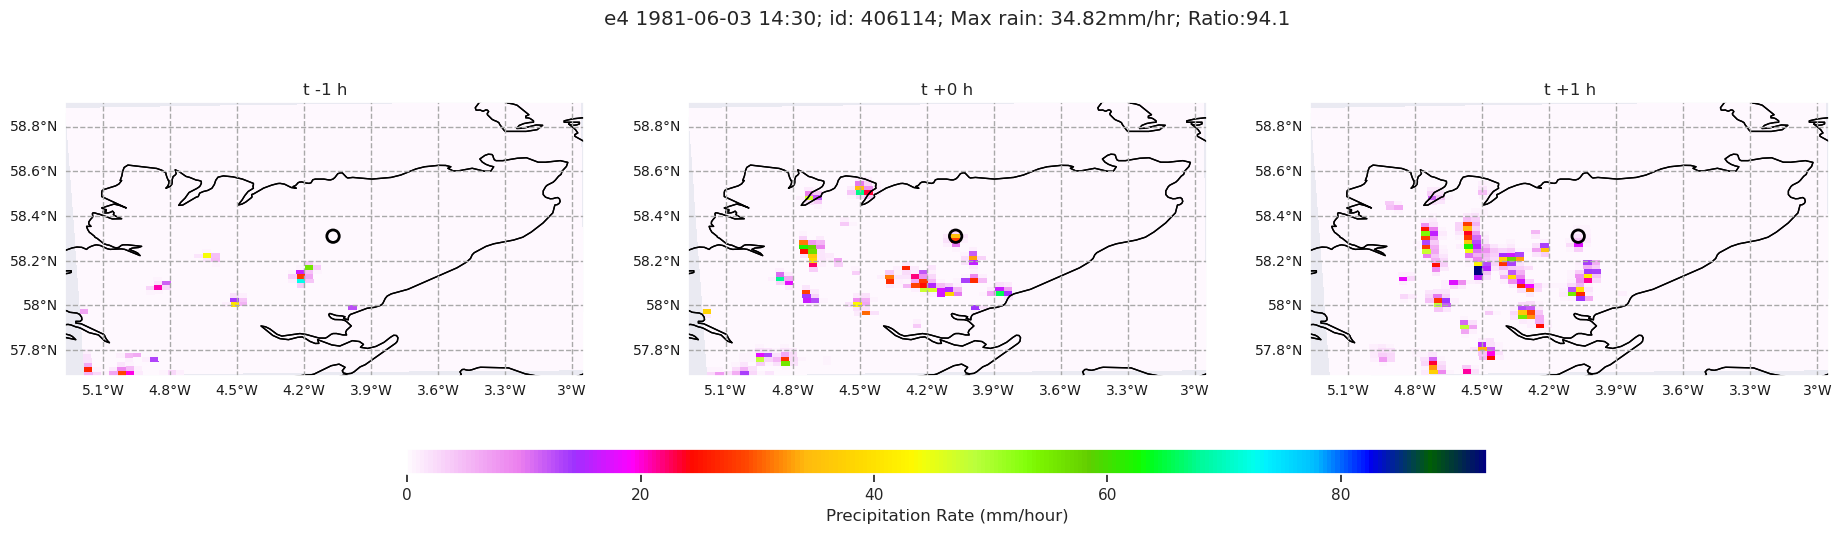

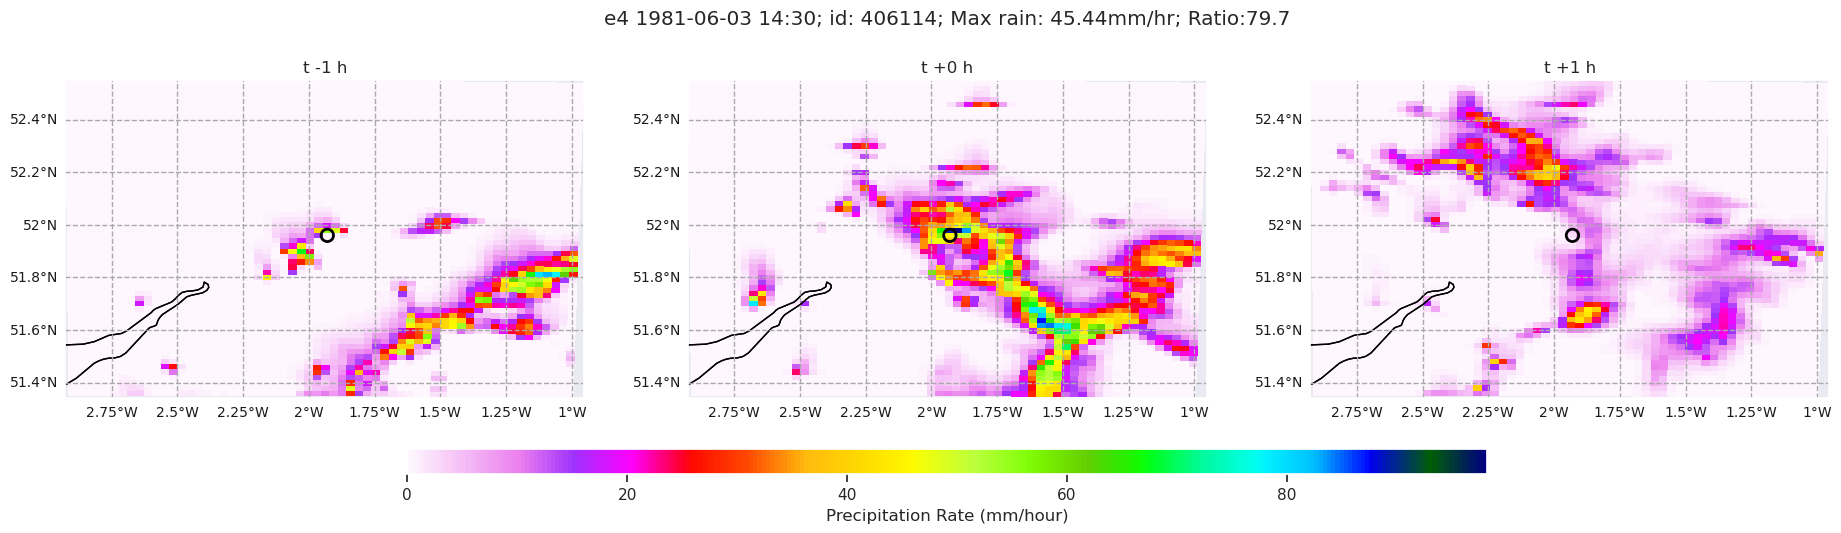

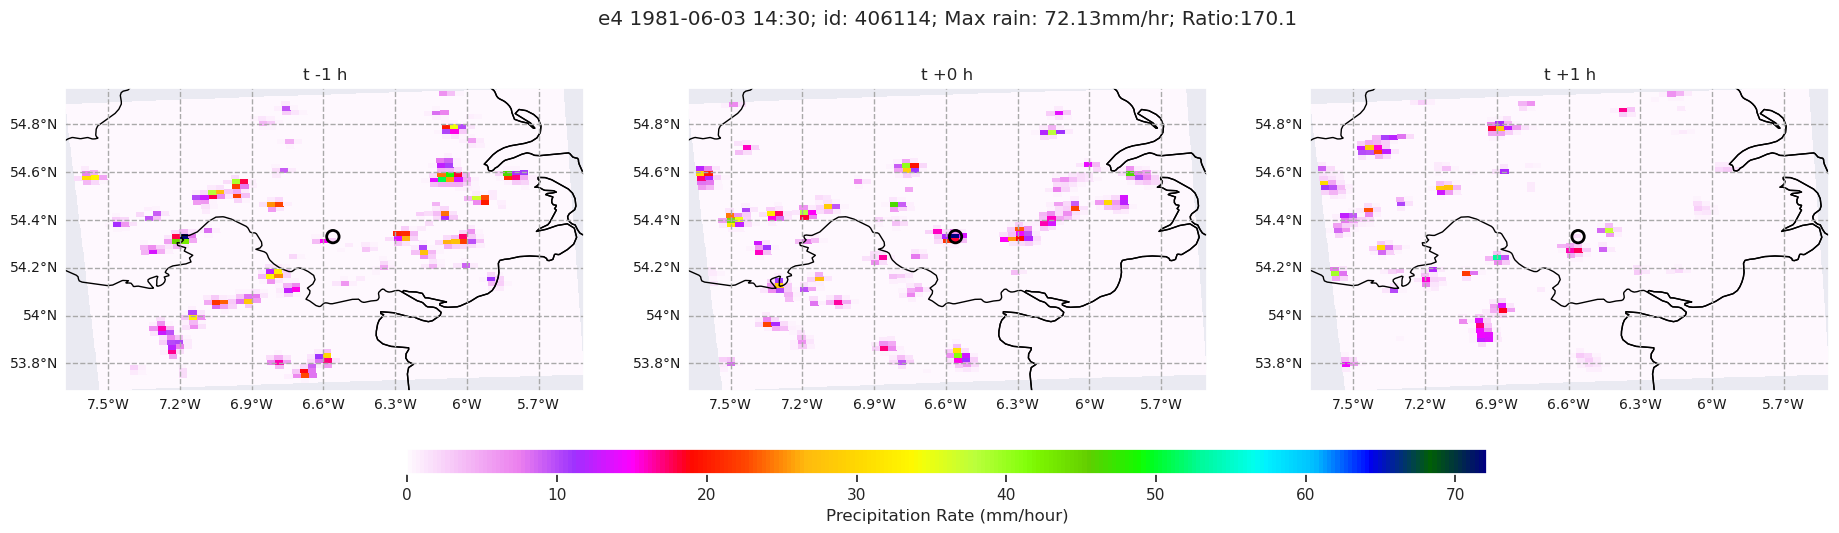

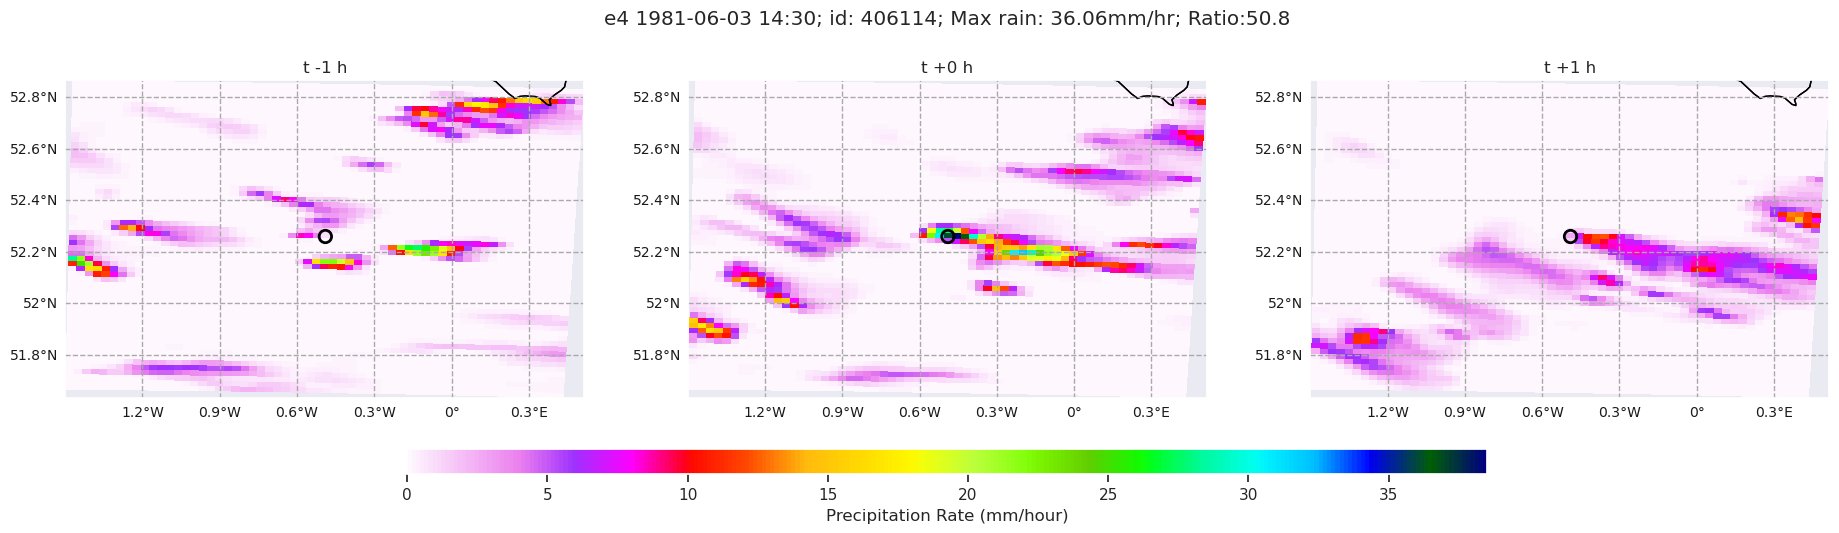

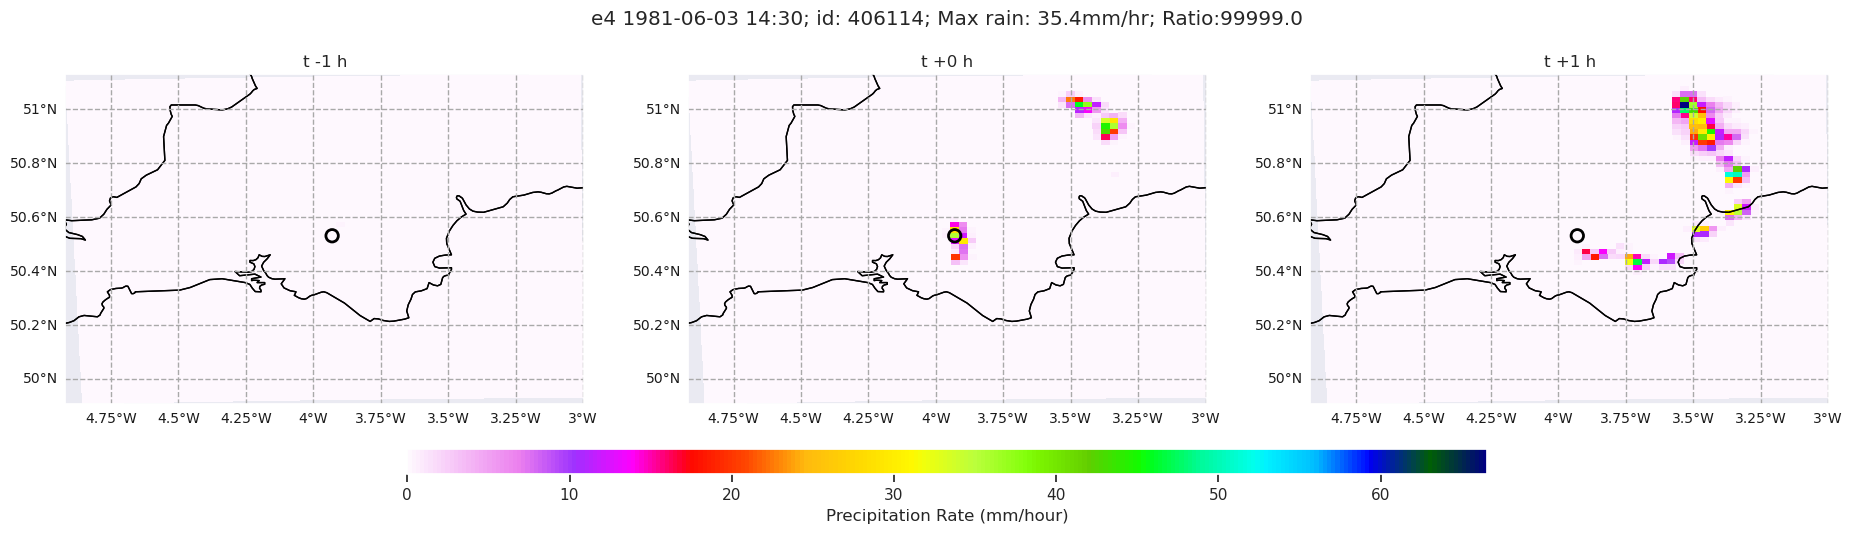

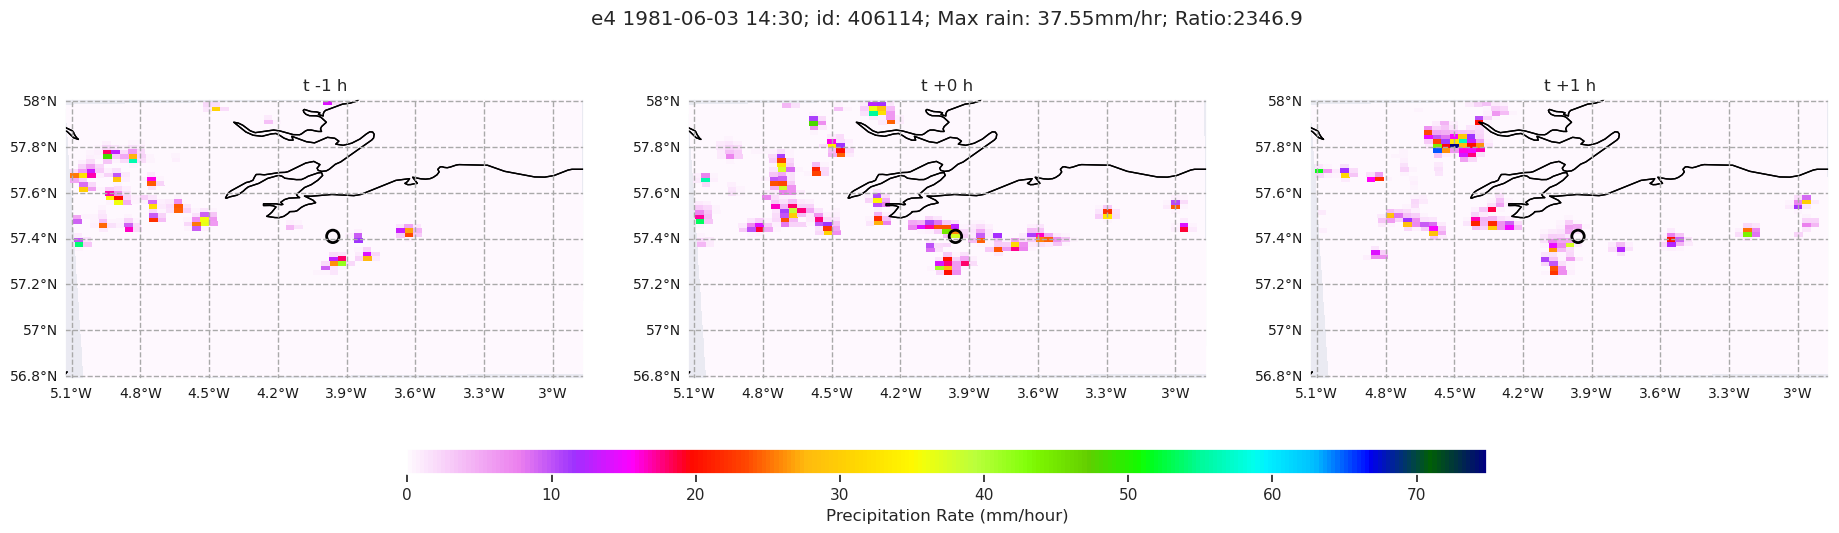

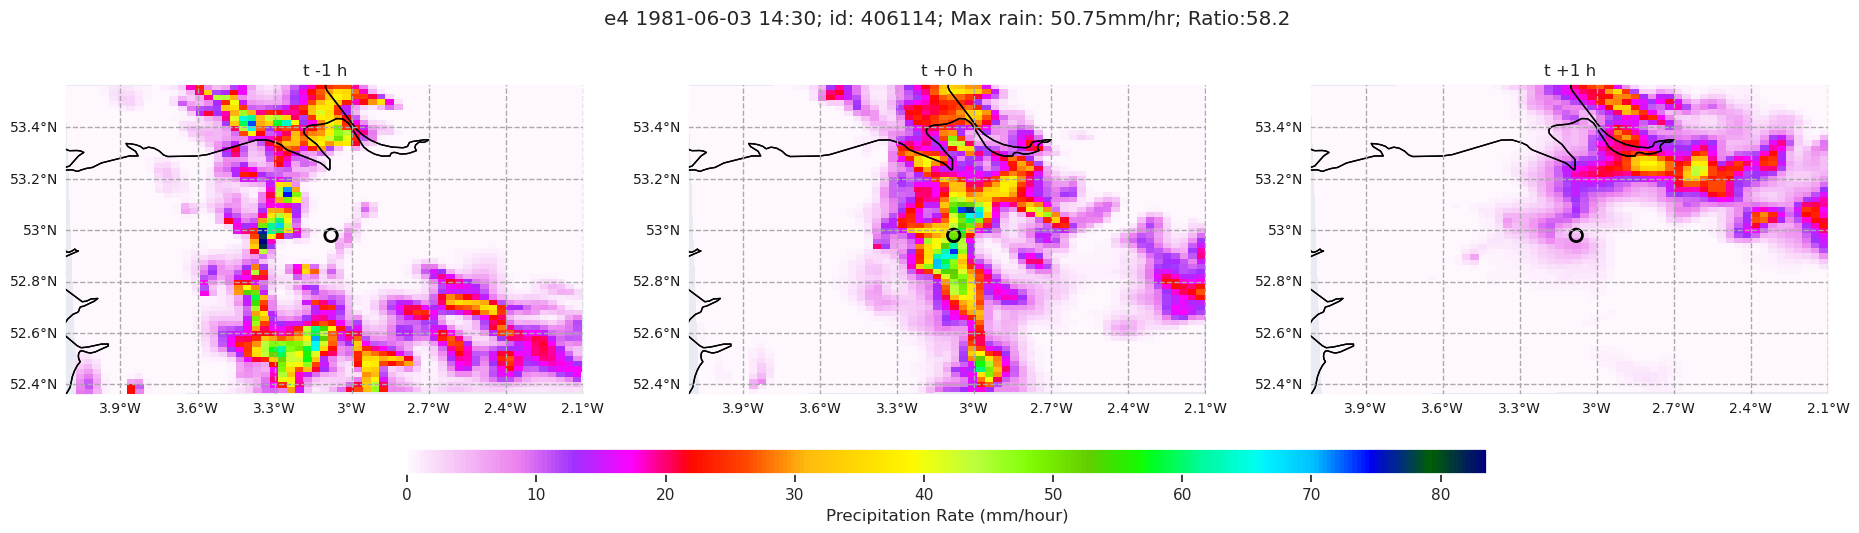

In [12]:
make_plot(cube, prof)
for i in range(n_plots):
    make_plot(cube, sub_rainfall.iloc[[(i*10)]])
